In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import re, struct


from typing import Dict

import warnings

/opt/python37/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

2022-09-05 13:17:50.876593: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-09-05 13:17:50.876626: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/askorohodov/.local/lib/python3.7/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.visualization import plot_result
from src.models.simple_models import OCSVM, LOF, iForest
from src.models.ae_lstm import AE_LSTM
from src.models.som import SOM

In [4]:
model_store_path = './saved_models/'

In [5]:
#pd.set_option('display.max_rows', 150)

# Загрузка данных

In [6]:
data = pd.read_csv('/opt/notebooks/cerebrum/CISS2022/ARPE/splitted_payload_192_168_1_10.csv', 
                   index_col='timestamp', 
                   parse_dates=True,
                   infer_datetime_format = True)
data.head(3)

path    id  \
timestamp                                                               
1.575598e+09  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...  1107   
1.575598e+09  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...  1108   
1.575598e+09  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...  3873   

                    connection_id  \
timestamp                           
1.575598e+09  b'\x80\x00\xfe\xb3'   
1.575598e+09  b'\x80\x00\xfe\xb3'   
1.575598e+09  b'\x80\x00\xfe\xb3'   

                                                       raw_data  len  \
timestamp                                                              
1.575598e+09  b"\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...  135   
1.575598e+09  b"\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...  135   
1.575598e+09  b"\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...  135   

                                                       int_data        0  \
timestamp                                                                  
1.575598e+09  (0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...  b'\x00'   
1.575598e+09  (0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...  b'\x00'   
1.575598e+09  (0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...  b'\x00'   

                    1        2        3  ...       71        72     73  \
timestamp                                ...                             
1.575598e+09  b'\x00'  b'\xff'  b'\xff'  ...  b'\xc0'  b'\x00>'  b"'z"   
1.575598e+09  b'\x00'  b'\xff'  b'\xff'  ...  b'\xc0'  b'\x00>'  b"'z"   
1.575598e+09  b'\x00'  b'\xff'  b'\xff'  ...  b'\xc0'  b'\x00>'  b"'z"   

                    74           75           76           77           78  \
timestamp                                                                    
1.575598e+09  b'\xab>'  b'\x05\xfa'  b'\xab\x00'  b'\x01\x00'  b'\x00\x00'   
1.575598e+09  b'\xab>'  b'\x05\xfa'  b'\xab\x00'  b'\x01\x00'  b'\x00\x00'   
1.575598e+09  b'\xab>'  b'\x05\xfa'  b'\xab\x00'  b'\x01\x00'  b'\x00\x00'   

                   79               80  
timestamp                               
1.575598e+09  b'\xcc'  b'\xcc\xad\xc0'  
1.575598e+09  b'\xcc'  b'\xcc\xad\xc0'  
1.575598e+09  b'\xcc'  b'\xcc\xad\xc1'  

[3 rows x 87 columns]

In [7]:
data.index = pd.to_datetime(data.index, unit='s')
data.head(3)

path  \
timestamp                                                                          
2019-12-06 02:05:04.415631056  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...   
2019-12-06 02:05:04.415632010  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...   
2019-12-06 02:05:04.532814026  /opt/datasets/cerebrum/SWAT/SWaT.A6_Dec 2019/D...   

                                 id        connection_id  \
timestamp                                                  
2019-12-06 02:05:04.415631056  1107  b'\x80\x00\xfe\xb3'   
2019-12-06 02:05:04.415632010  1108  b'\x80\x00\xfe\xb3'   
2019-12-06 02:05:04.532814026  3873  b'\x80\x00\xfe\xb3'   

                                                                        raw_data  \
timestamp                                                                          
2019-12-06 02:05:04.415631056  b"\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...   
2019-12-06 02:05:04.415632010  b"\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...   
2019-12-06 02:05:04.532814026  b"\x00\x00\x00\x00\xff\xff\xff\xff\x00\x03B\xe...   

                               len  \
timestamp                            
2019-12-06 02:05:04.415631056  135   
2019-12-06 02:05:04.415632010  135   
2019-12-06 02:05:04.532814026  135   

                                                                        int_data  \
timestamp                                                                          
2019-12-06 02:05:04.415631056  (0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...   
2019-12-06 02:05:04.415632010  (0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...   
2019-12-06 02:05:04.532814026  (0, 0, 0, 0, 255, 255, 255, 255, 0, 3, 66, 231...   

                                     0        1        2        3  ...  \
timestamp                                                          ...   
2019-12-06 02:05:04.415631056  b'\x00'  b'\x00'  b'\xff'  b'\xff'  ...   
2019-12-06 02:05:04.415632010  b'\x00'  b'\x00'  b'\xff'  b'\xff'  ...   
2019-12-06 02:05:04.532814026  b'\x00'  b'\x00'  b'\xff'  b'\xff'  ...   

                                    71        72     73        74  \
timestamp                                                           
2019-12-06 02:05:04.415631056  b'\xc0'  b'\x00>'  b"'z"  b'\xab>'   
2019-12-06 02:05:04.415632010  b'\xc0'  b'\x00>'  b"'z"  b'\xab>'   
2019-12-06 02:05:04.532814026  b'\xc0'  b'\x00>'  b"'z"  b'\xab>'   

                                        75           76           77  \
timestamp                                                              
2019-12-06 02:05:04.415631056  b'\x05\xfa'  b'\xab\x00'  b'\x01\x00'   
2019-12-06 02:05:04.415632010  b'\x05\xfa'  b'\xab\x00'  b'\x01\x00'   
2019-12-06 02:05:04.532814026  b'\x05\xfa'  b'\xab\x00'  b'\x01\x00'   

                                        78       79               80  
timestamp                                                             
2019-12-06 02:05:04.415631056  b'\x00\x00'  b'\xcc'  b'\xcc\xad\xc0'  
2019-12-06 02:05:04.415632010  b'\x00\x00'  b'\xcc'  b'\xcc\xad\xc0'  
2019-12-06 02:05:04.532814026  b'\x00\x00'  b'\xcc'  b'\xcc\xad\xc1'  

[3 rows x 87 columns]

### Работаем с INT

In [8]:
df_int = data.copy()[['id', 'int_data']]
df_int['int_data'] = df_int['int_data'].apply(lambda x: x[1:-1].split(','))
df_int

id  \
timestamp                                 
2019-12-06 02:05:04.415631056      1107   
2019-12-06 02:05:04.415632010      1108   
2019-12-06 02:05:04.532814026      3873   
2019-12-06 02:05:04.532814980      3874   
2019-12-06 02:05:04.913991928     14933   
...                                 ...   
2019-12-06 05:45:02.793700933  21902947   
2019-12-06 05:45:03.292222023  21915746   
2019-12-06 05:45:03.292222977  21915747   
2019-12-06 05:45:03.796188116  21927579   
2019-12-06 05:45:03.796189070  21927580   

                                                                        int_data  
timestamp                                                                         
2019-12-06 02:05:04.415631056  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 02:05:04.415632010  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 02:05:04.532814026  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 02:05:04.532814980  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 02:05:04.913991928  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
...                                                                          ...  
2019-12-06 05:45:02.793700933  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 05:45:03.292222023  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 05:45:03.292222977  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 05:45:03.796188116  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 05:45:03.796189070  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  

[86800 rows x 2 columns]

In [9]:
df_int = df_int[~df_int.index.duplicated(keep='first')].sort_index()
df_int

id  \
timestamp                                 
2019-12-06 02:05:04.415631056      1107   
2019-12-06 02:05:04.415632010      1108   
2019-12-06 02:05:04.532814026      3873   
2019-12-06 02:05:04.532814980      3874   
2019-12-06 02:05:04.913991928     14933   
...                                 ...   
2019-12-06 05:45:02.793700933  21902947   
2019-12-06 05:45:03.292222023  21915746   
2019-12-06 05:45:03.292222977  21915747   
2019-12-06 05:45:03.796188116  21927579   
2019-12-06 05:45:03.796189070  21927580   

                                                                        int_data  
timestamp                                                                         
2019-12-06 02:05:04.415631056  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 02:05:04.415632010  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 02:05:04.532814026  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 02:05:04.532814980  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 02:05:04.913991928  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
...                                                                          ...  
2019-12-06 05:45:02.793700933  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 05:45:03.292222023  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 05:45:03.292222977  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 05:45:03.796188116  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  
2019-12-06 05:45:03.796189070  [0,  0,  0,  0,  255,  255,  255,  255,  0,  3...  

[84402 rows x 2 columns]

Вытащим элементы списка в отдельные признаки

In [10]:
df_bytes_ = pd.DataFrame(df_int['int_data'].to_list(), 
                         columns=[str(i) for i in range(135)], 
                         index=df_int.index)

In [11]:
constant_columns = []

for col in df_bytes_.columns:
    col_unique_values = df_bytes_[col].unique()
    if col_unique_values.shape[0]==1:
        constant_columns.append(col)

print('constant:', constant_columns, 'lenght:', len(constant_columns))

df_bytes_ = df_bytes_.drop(constant_columns, axis=1)  
df_bytes_converted = df_bytes_.applymap(int)
df_bytes_converted.columns = ['byte_' + x for x in df_bytes_converted.columns]
df_bytes_converted

constant: ['0', '1', '2', '3', '4', '5', '6', '8', '9', '10', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '31', '32', '33', '34', '36', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '50', '54', '55', '57', '58', '60', '62', '63', '65', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '89', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132'] lenght: 102


byte_7  byte_11  byte_12  byte_13  byte_30  \
timestamp                                                                   
2019-12-06 02:05:04.415631056     255      231       59      188        1   
2019-12-06 02:05:04.415632010     255      231       59      188        1   
2019-12-06 02:05:04.532814026     255      231       59      188        1   
2019-12-06 02:05:04.532814980     255      231       59      188        1   
2019-12-06 02:05:04.913991928     255      231       59      188        1   
...                               ...      ...      ...      ...      ...   
2019-12-06 05:45:02.793700933     255      235      221      222        1   
2019-12-06 05:45:03.292222023     255      235      221      222        1   
2019-12-06 05:45:03.292222977     255      235      221      222        1   
2019-12-06 05:45:03.796188116     255      235      221      222        1   
2019-12-06 05:45:03.796189070     255      235      221      222        1   

                               byte_35  byte_37  byte_49  byte_51  byte_52  \
timestamp                                                                    
2019-12-06 02:05:04.415631056        1        3        2      105      153   
2019-12-06 02:05:04.415632010        1        3        2      105      153   
2019-12-06 02:05:04.532814026        1        3        2      105      153   
2019-12-06 02:05:04.532814980        1        3        2      105      153   
2019-12-06 02:05:04.913991928        1        3        2      105      153   
...                                ...      ...      ...      ...      ...   
2019-12-06 05:45:02.793700933        1        2        2      135       85   
2019-12-06 05:45:03.292222023        1        2        2      135       85   
2019-12-06 05:45:03.292222977        1        2        2      135       85   
2019-12-06 05:45:03.796188116        1        2        2      135       85   
2019-12-06 05:45:03.796189070        1        2        2      135       85   

                               ...  byte_91  byte_92  byte_109  byte_110  \
timestamp                      ...                                         
2019-12-06 02:05:04.415631056  ...       60      253         0         0   
2019-12-06 02:05:04.415632010  ...       60      253         0         0   
2019-12-06 02:05:04.532814026  ...       60      253         0         0   
2019-12-06 02:05:04.532814980  ...       60      253         0         0   
2019-12-06 02:05:04.913991928  ...       60      253         0         0   
...                            ...      ...      ...       ...       ...   
2019-12-06 05:45:02.793700933  ...      103       68         0         0   
2019-12-06 05:45:03.292222023  ...      103       68         0         0   
2019-12-06 05:45:03.292222977  ...      103       68         0         0   
2019-12-06 05:45:03.796188116  ...      103       68         0         0   
2019-12-06 05:45:03.796189070  ...      103       68         0         0   

                               byte_111  byte_112  byte_113  byte_114  \
timestamp                                                               
2019-12-06 02:05:04.415631056         0         0         0        12   
2019-12-06 02:05:04.415632010         0         0         0        12   
2019-12-06 02:05:04.532814026         0         0         0        12   
2019-12-06 02:05:04.532814980         0         0         0        12   
2019-12-06 02:05:04.913991928         0         0         0        12   
...                                 ...       ...       ...       ...   
2019-12-06 05:45:02.793700933         0         0         0        12   
2019-12-06 05:45:03.292222023         0         0         0        12   
2019-12-06 05:45:03.292222977         0         0         0        12   
2019-12-06 05:45:03.796188116         0         0         0        12   
2019-12-06 05:45:03.796189070         0         0         0        12   

                               byte_133  byte_134  
timestamp              

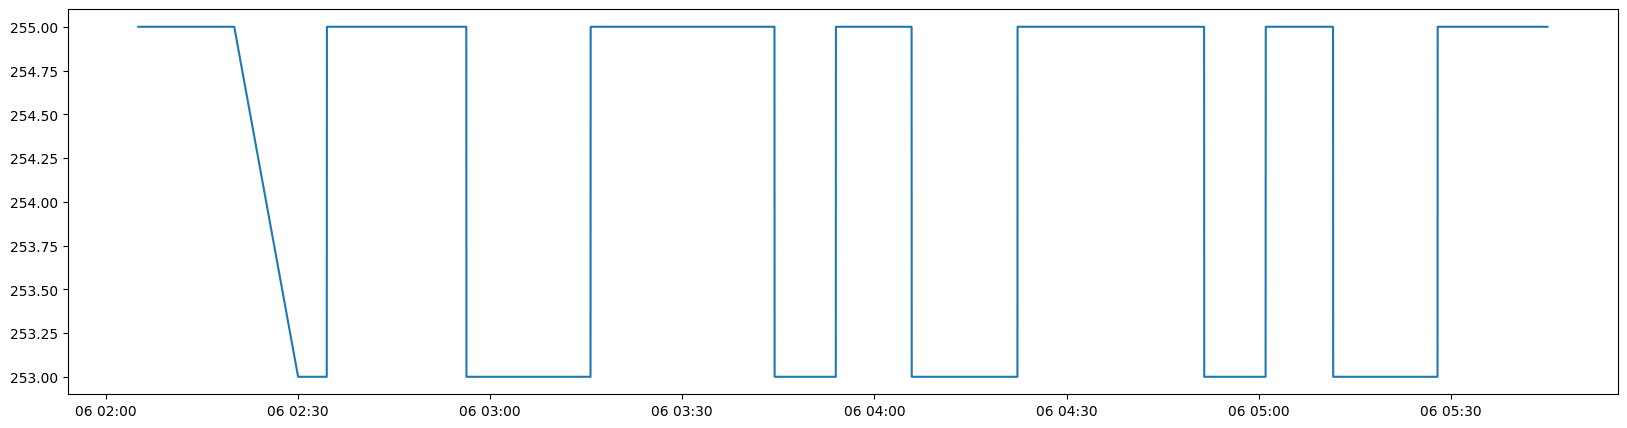

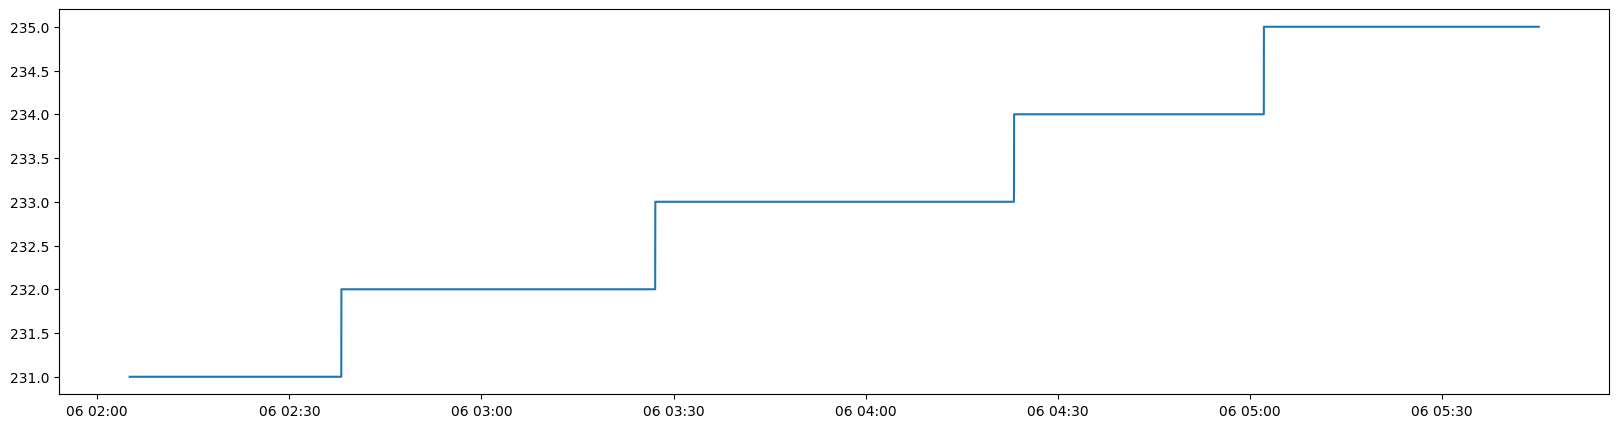

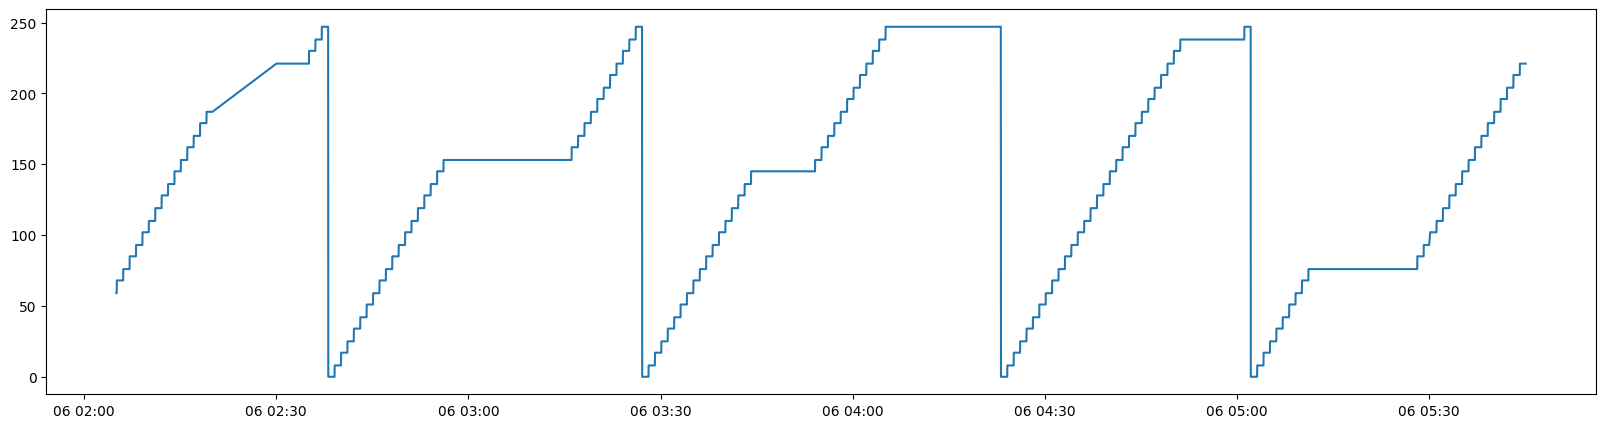

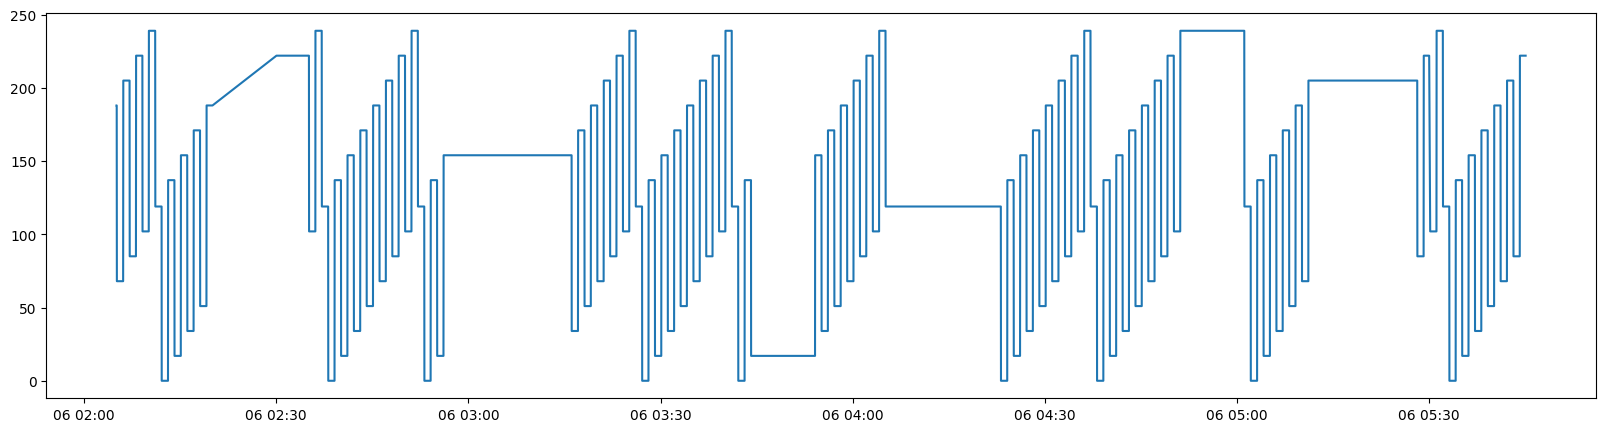

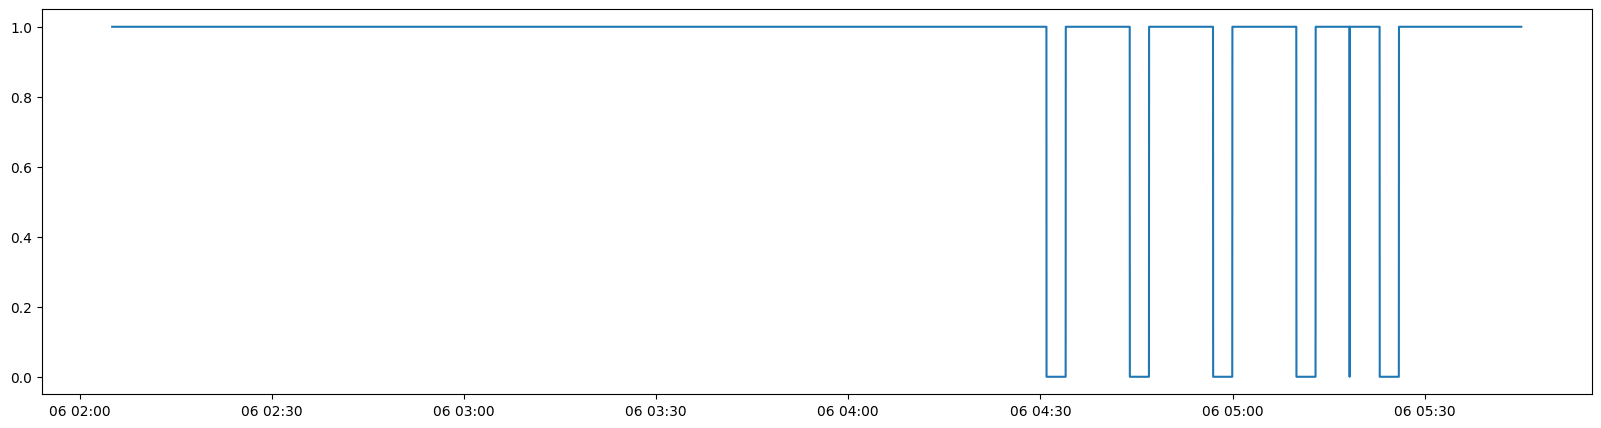

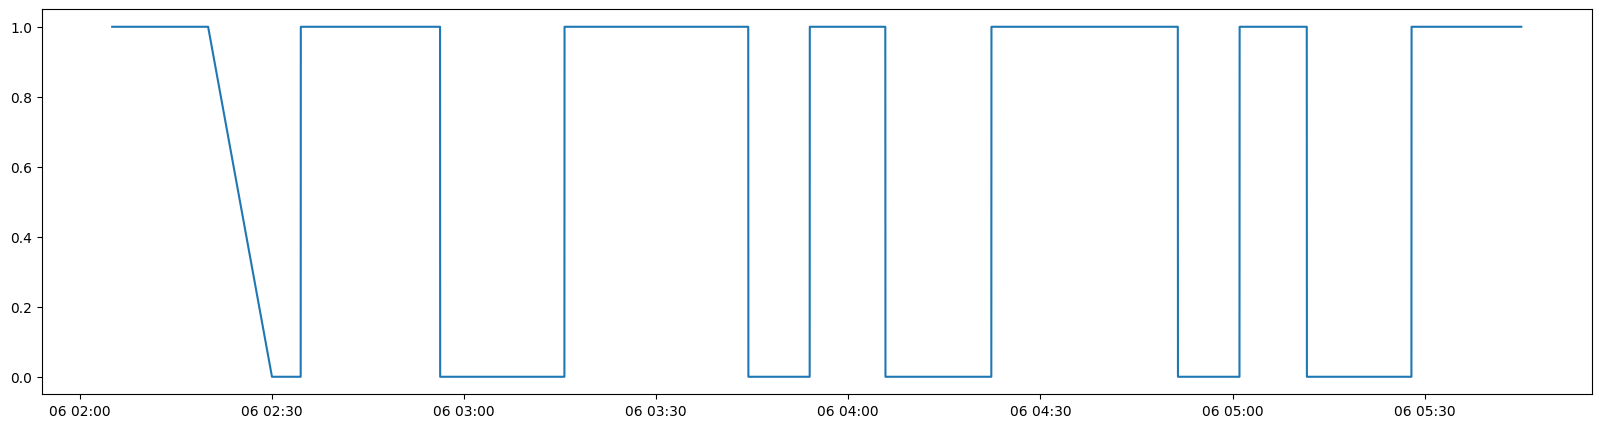

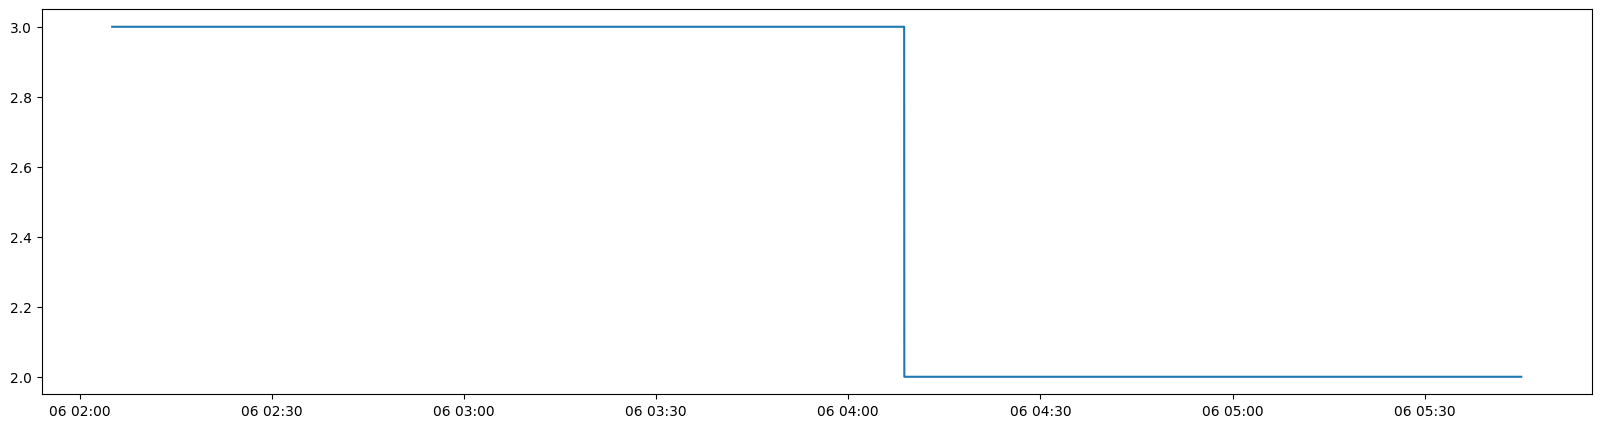

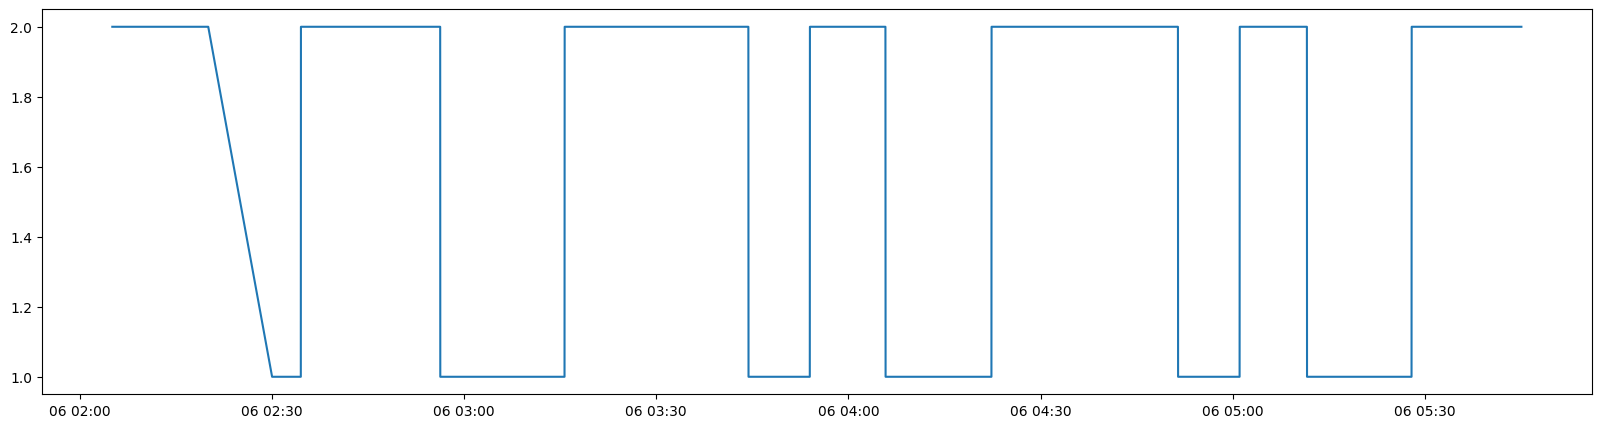

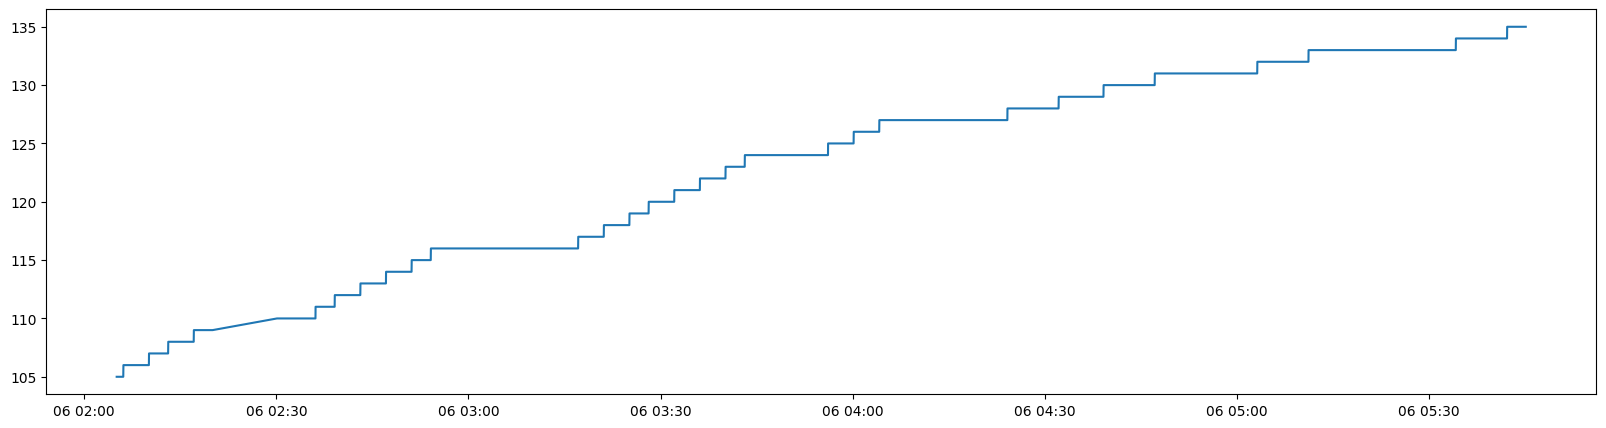

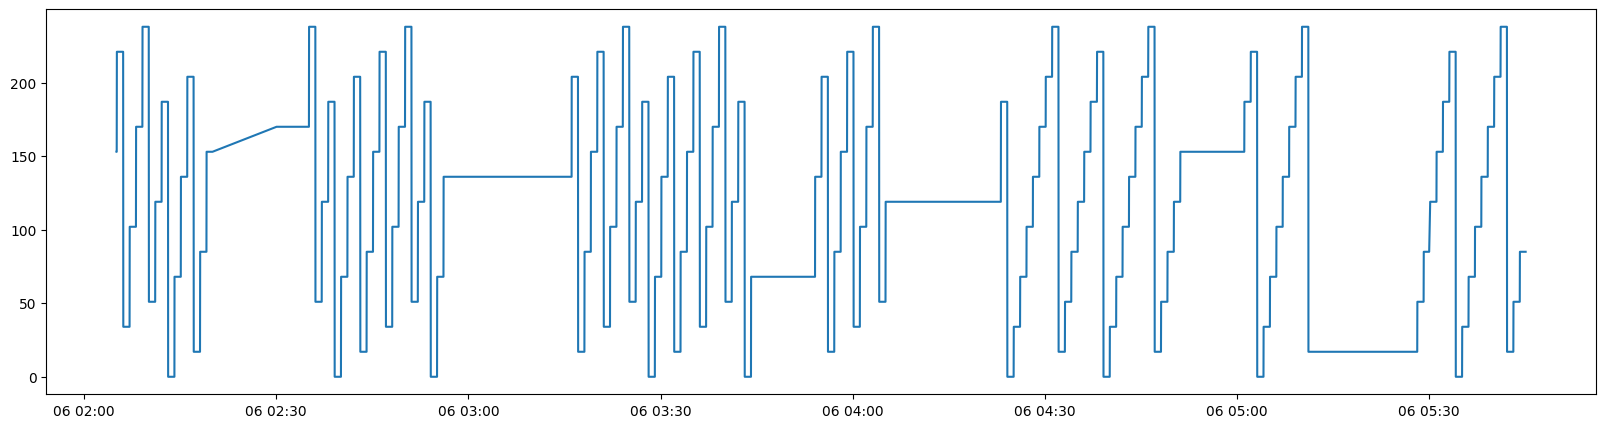

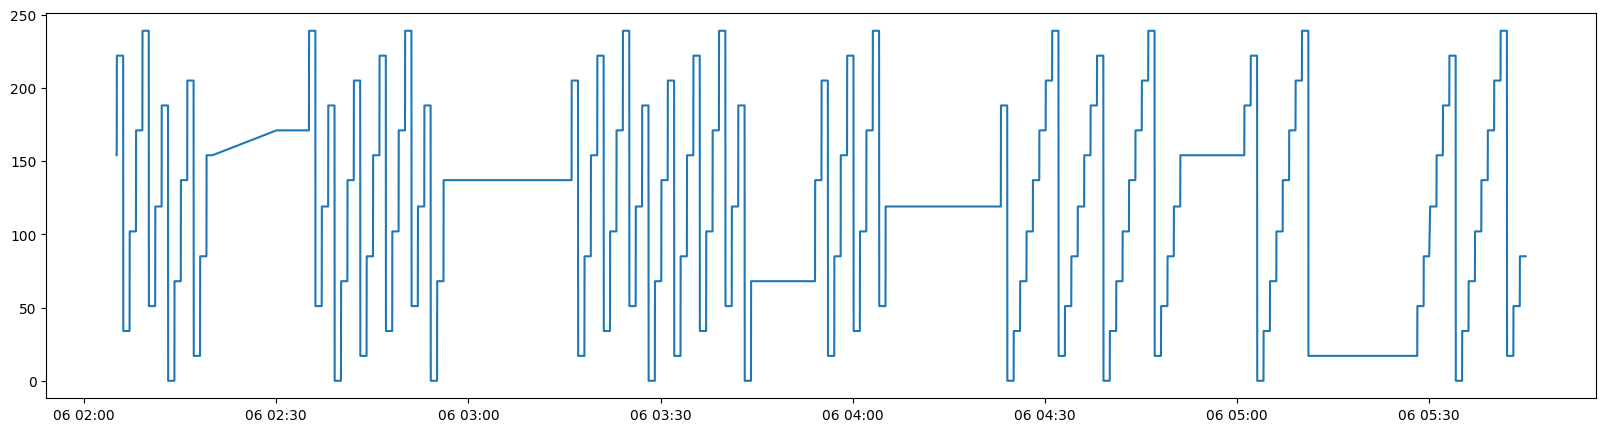

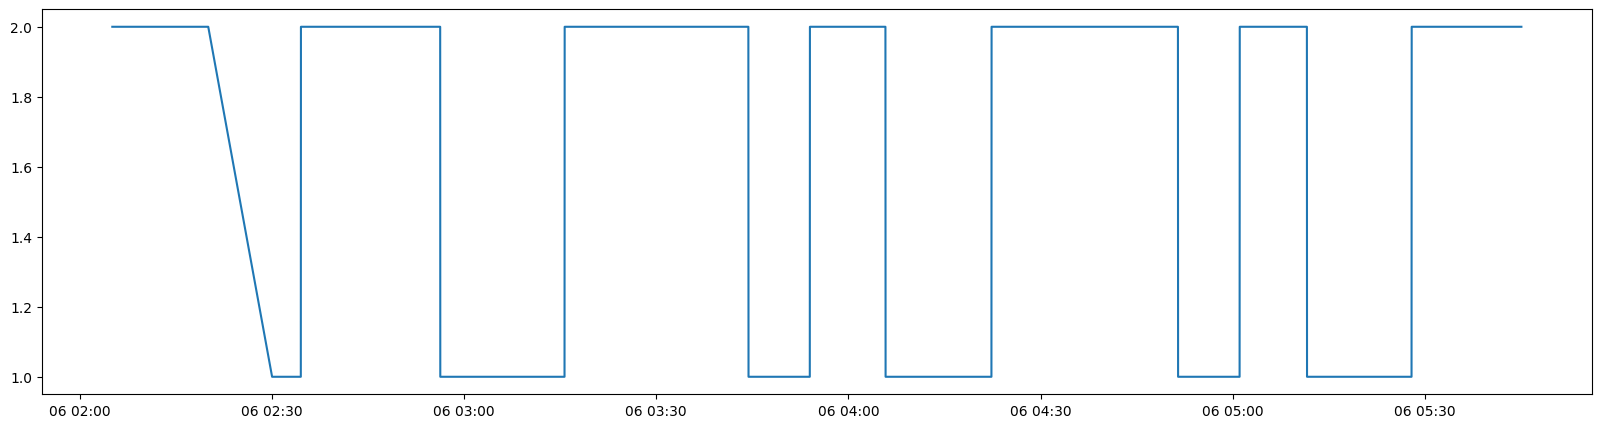

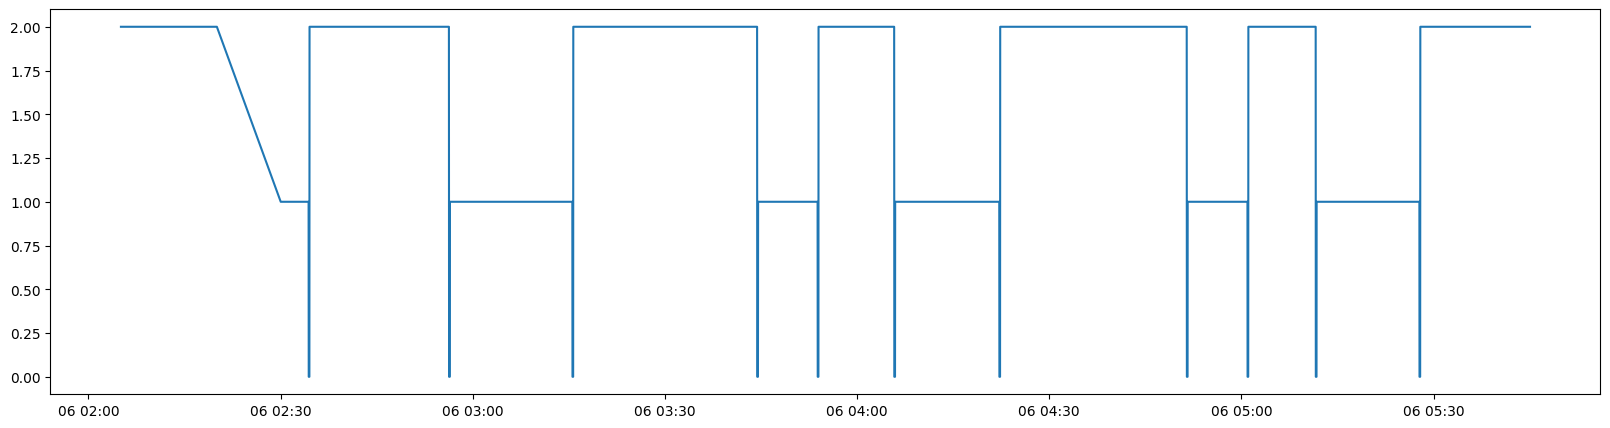

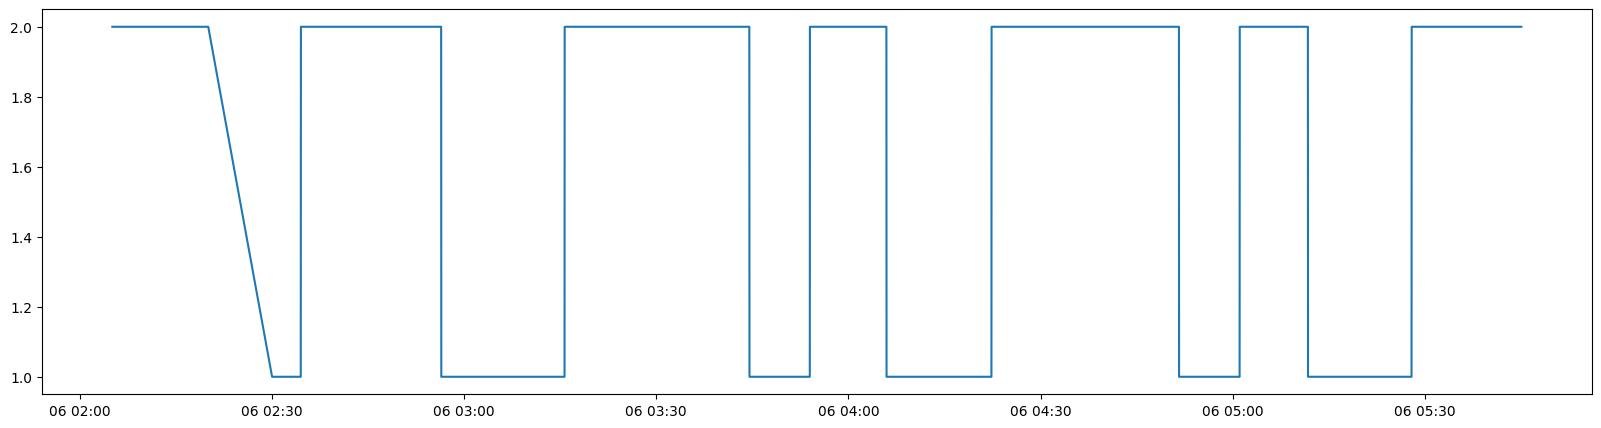

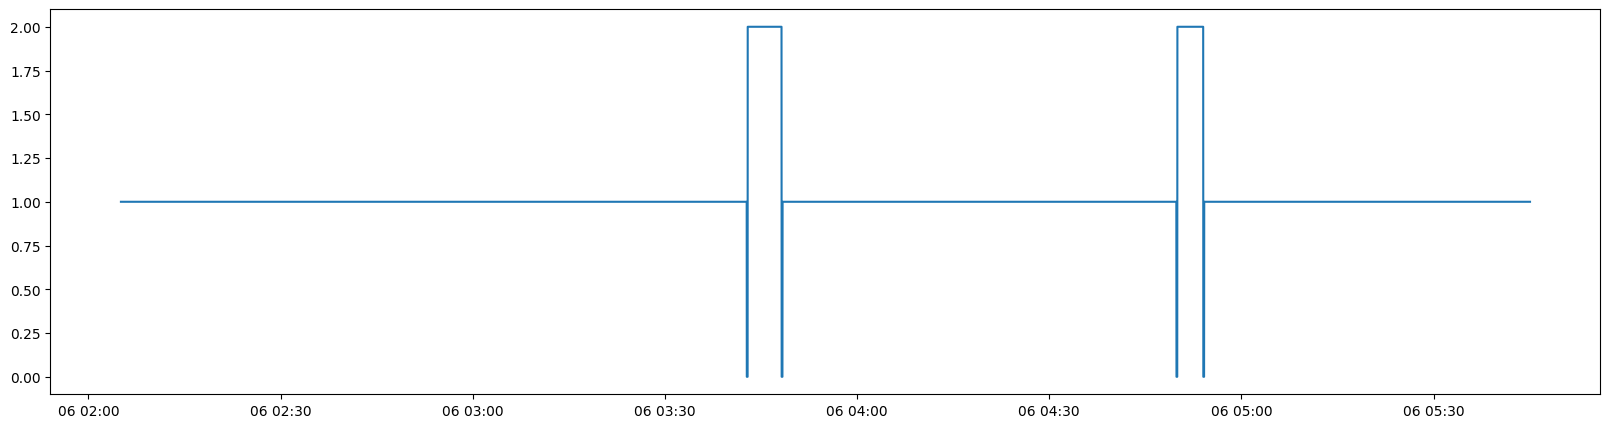

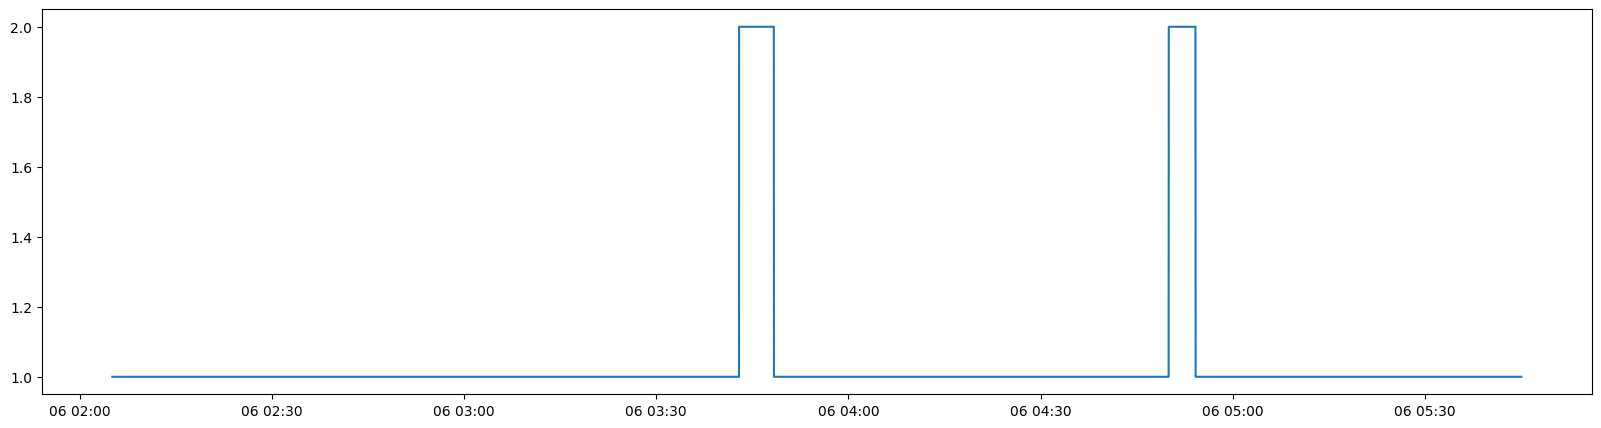

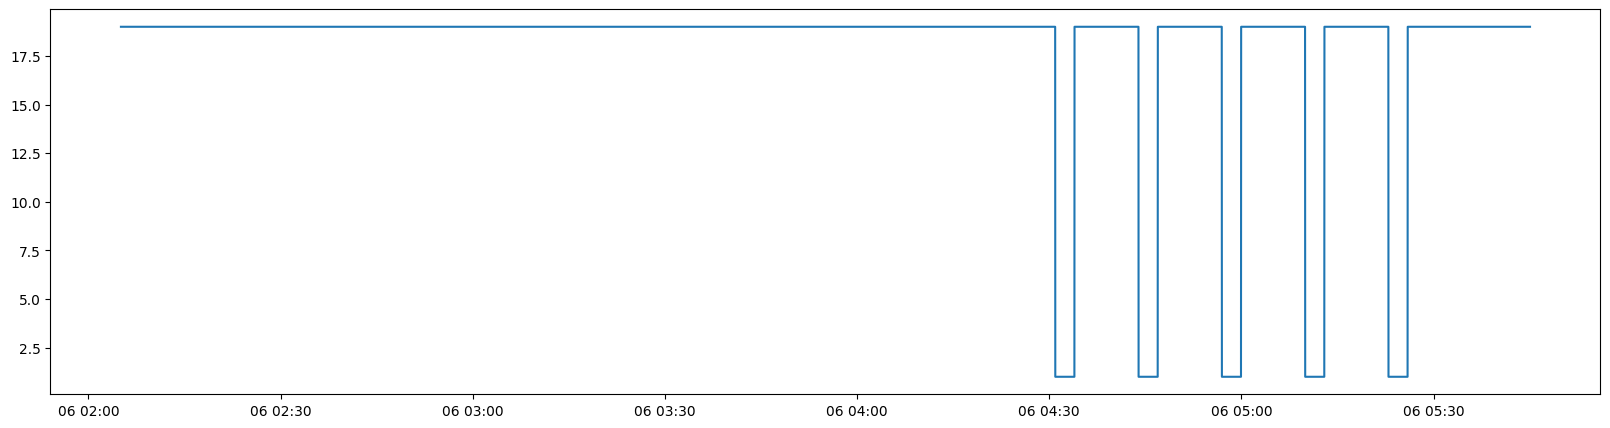

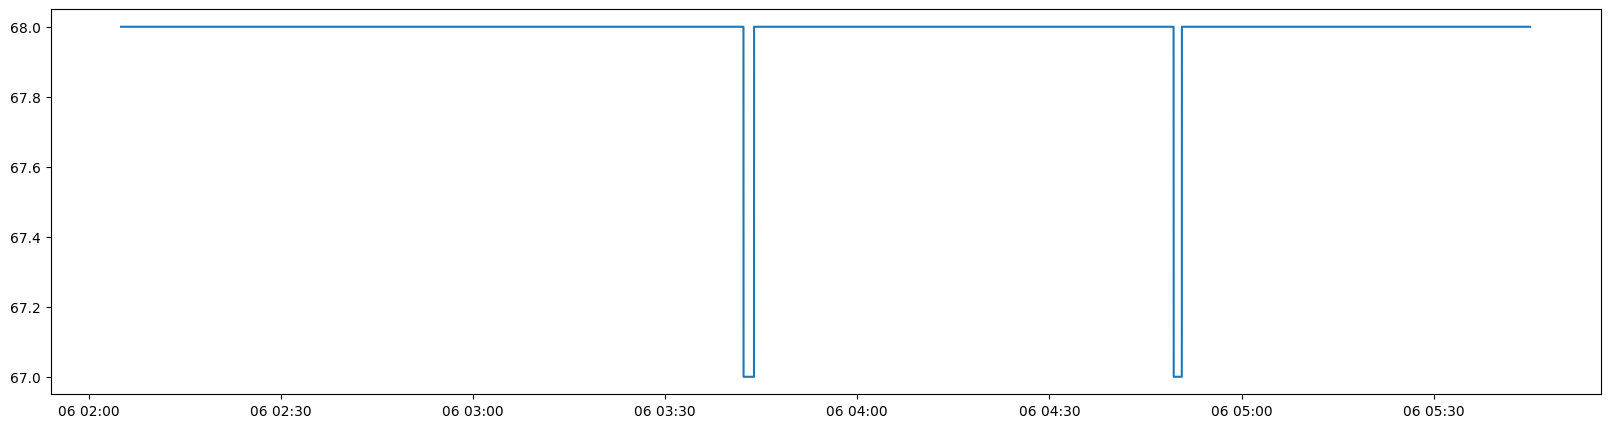

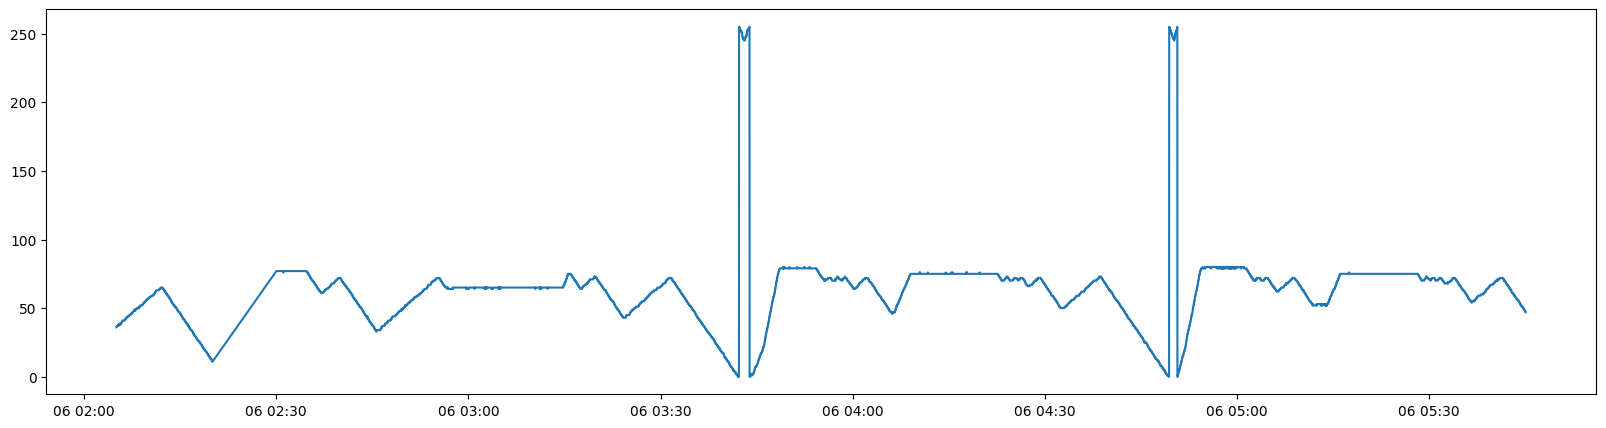

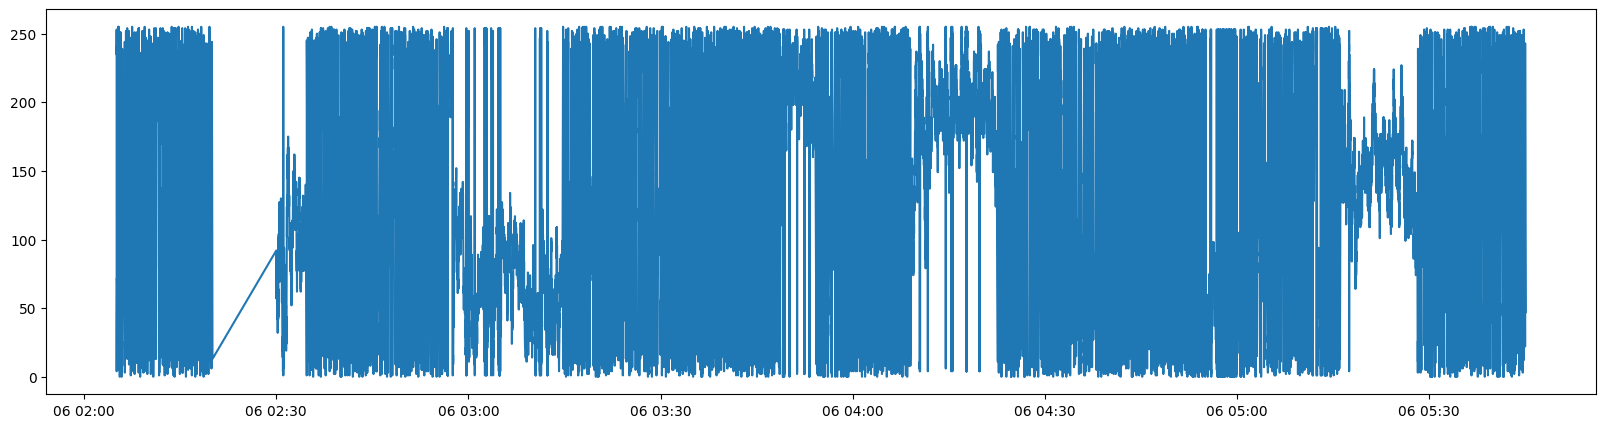

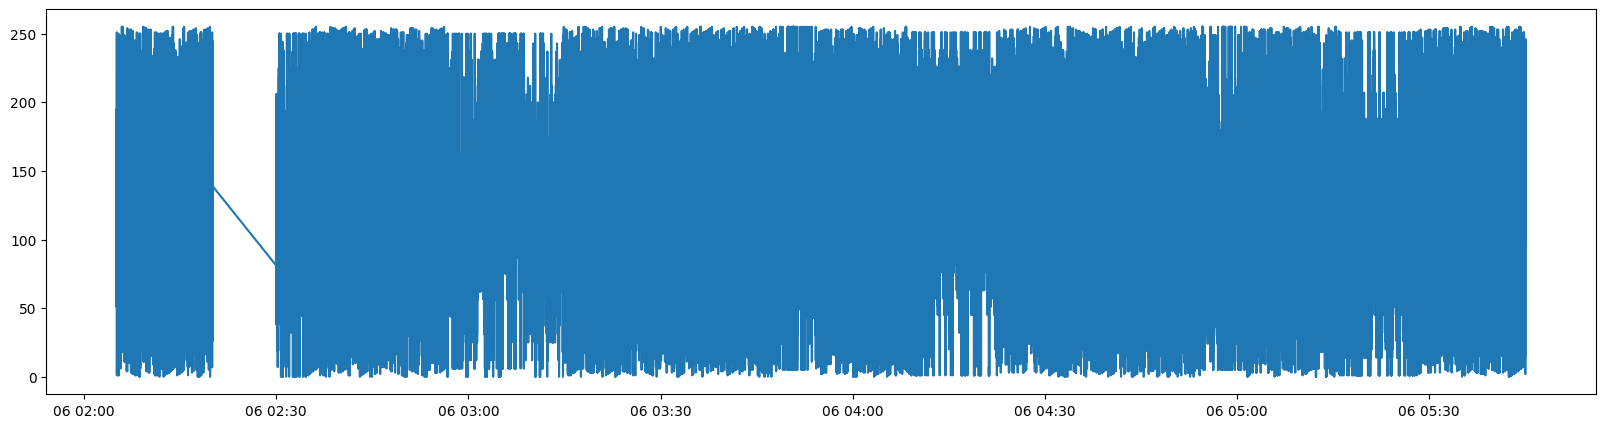

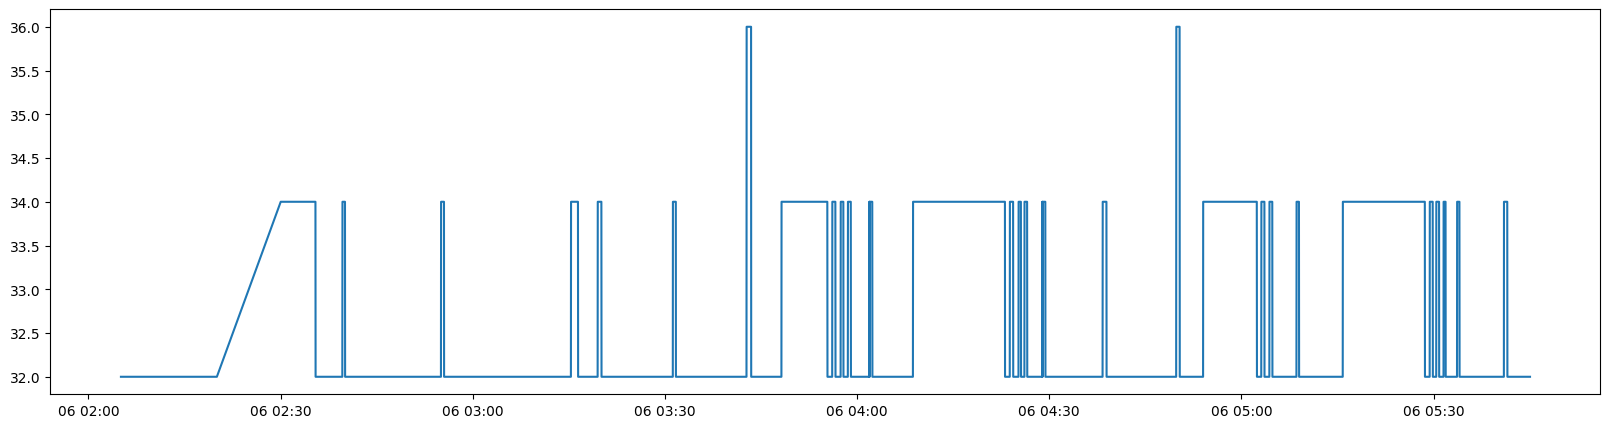

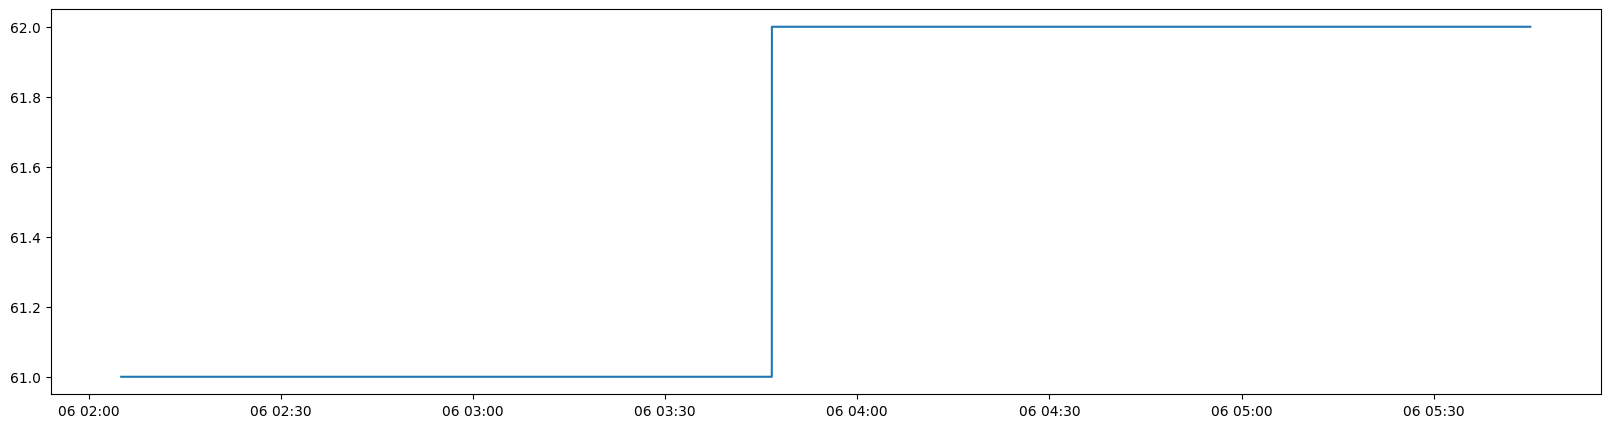

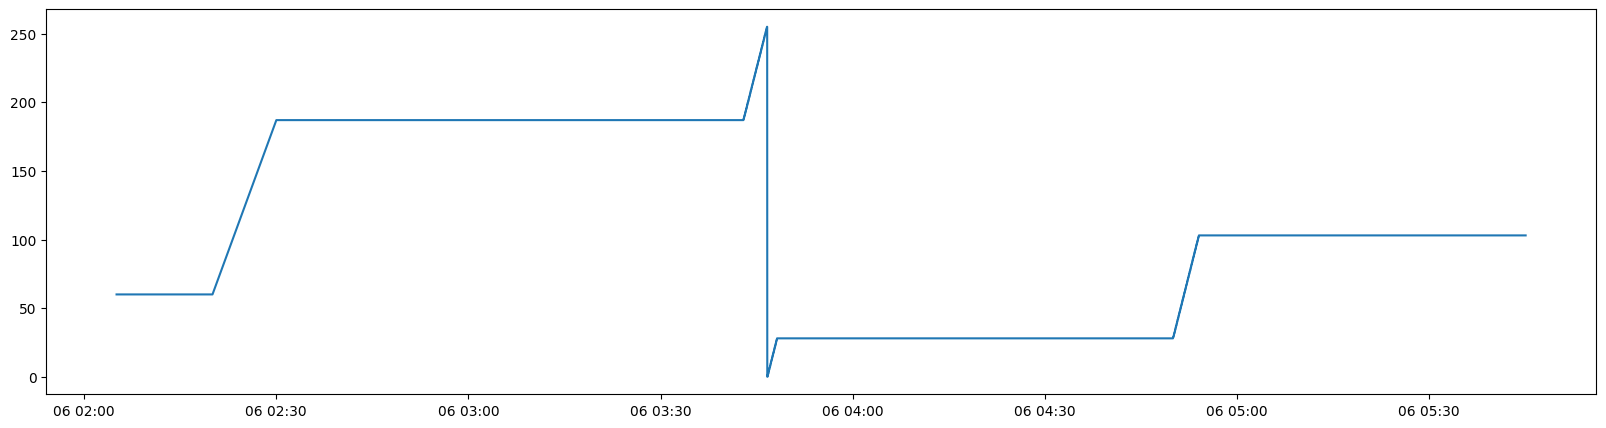

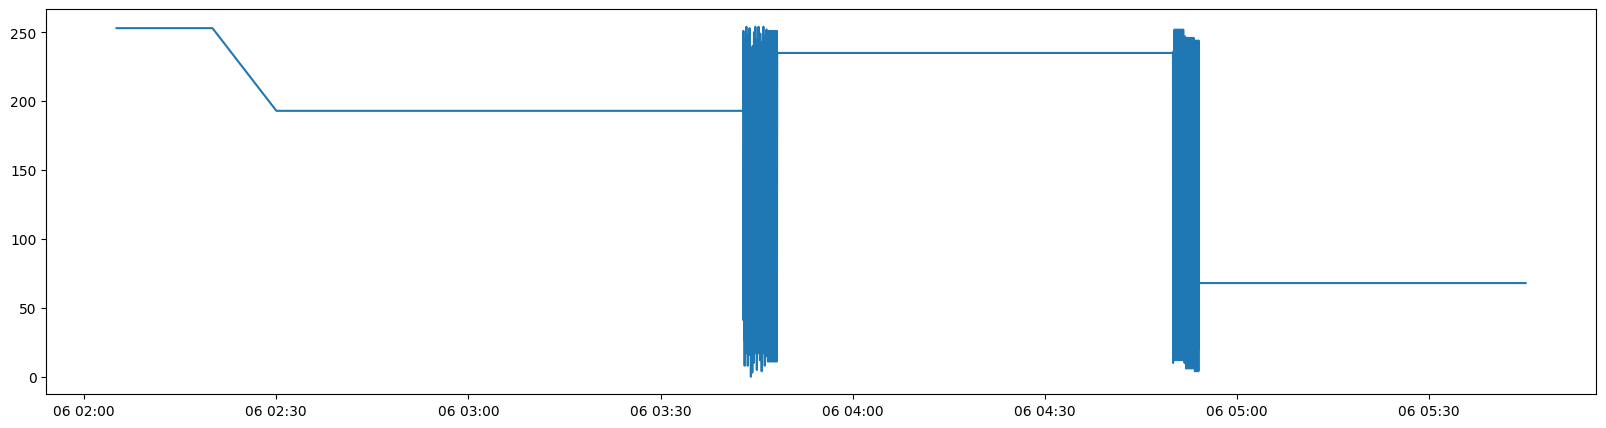

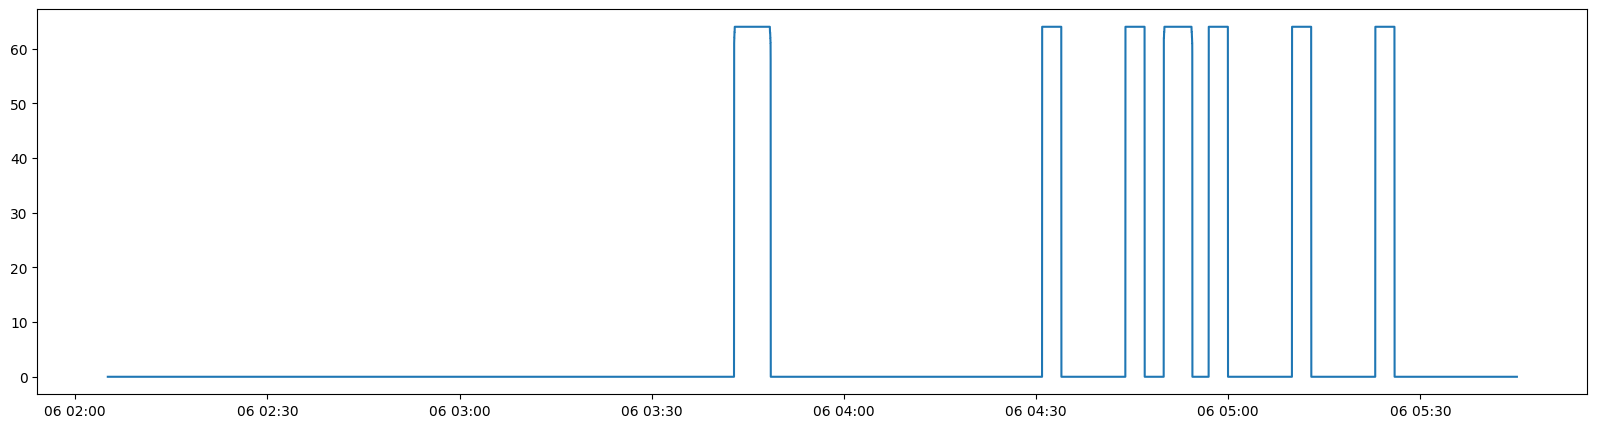

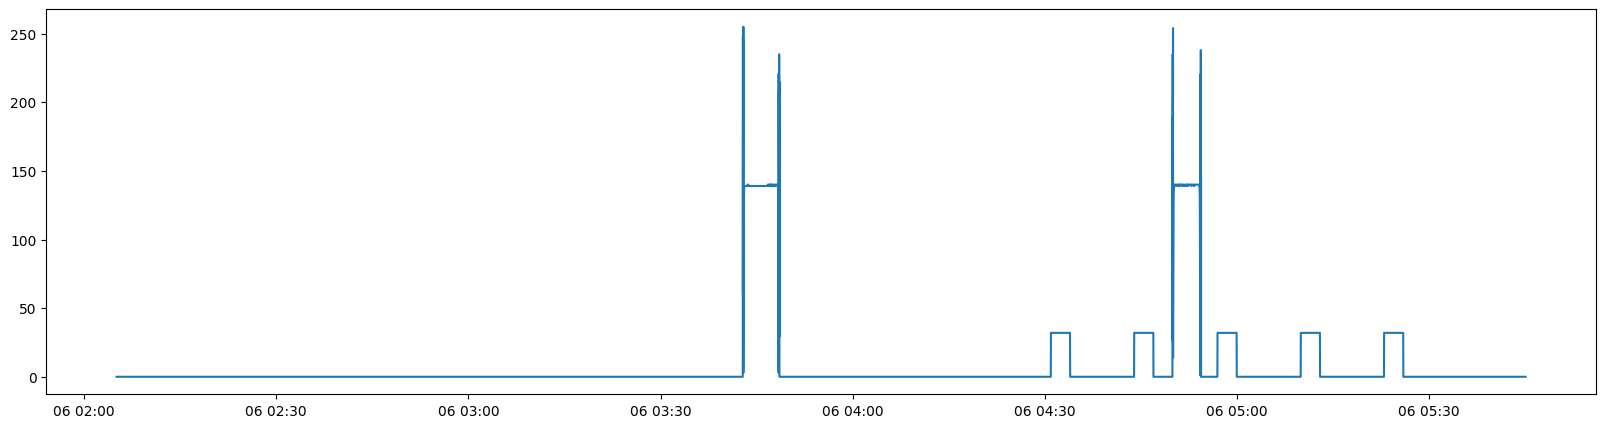

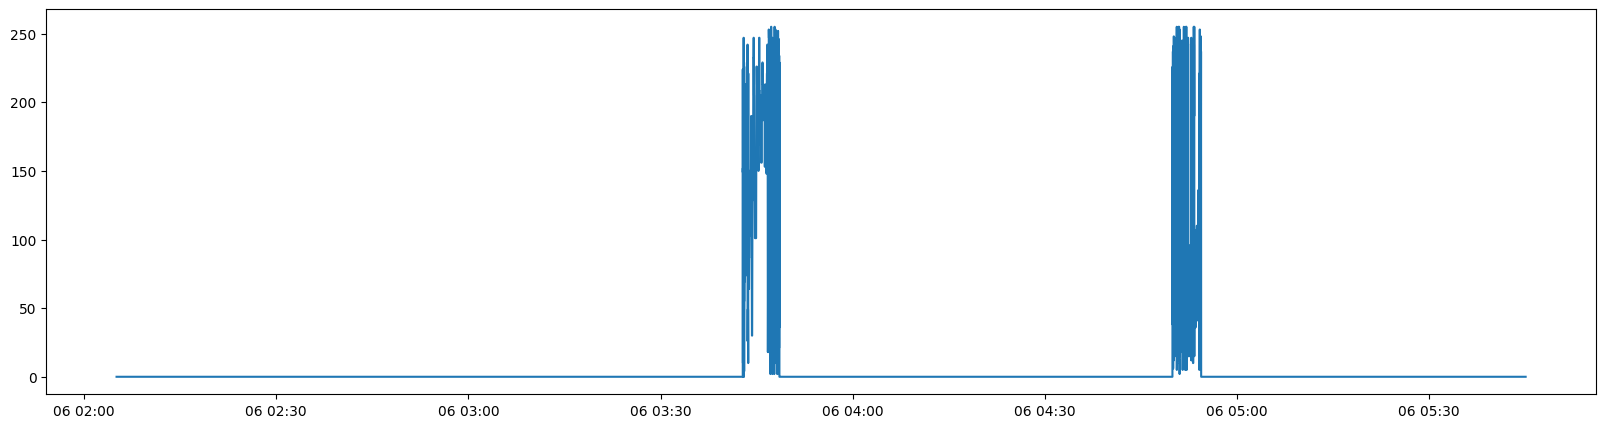

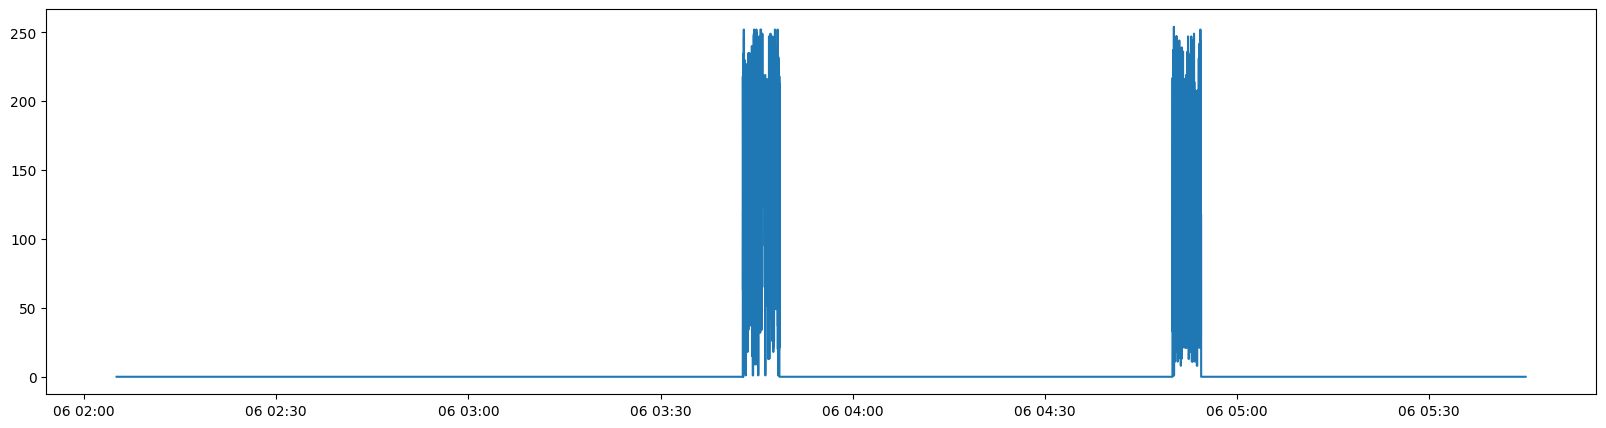

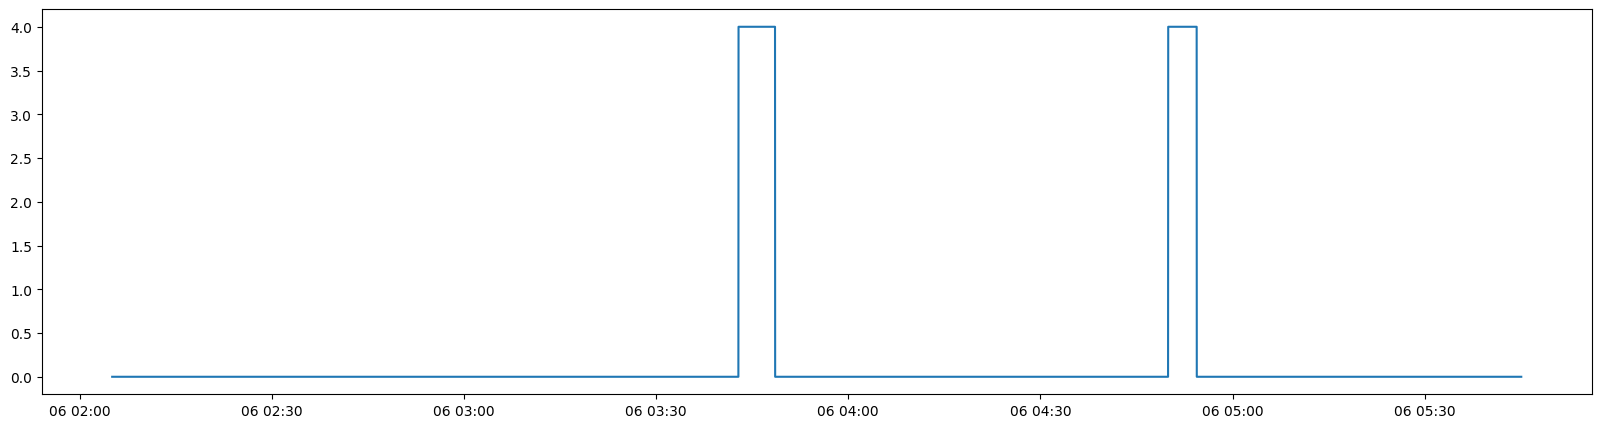

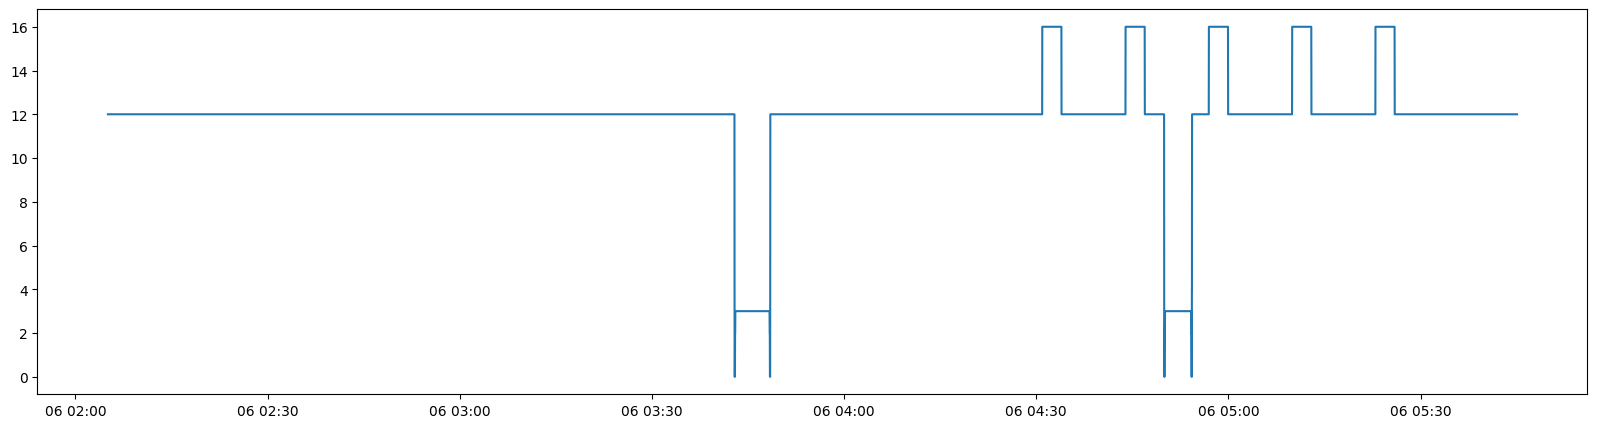

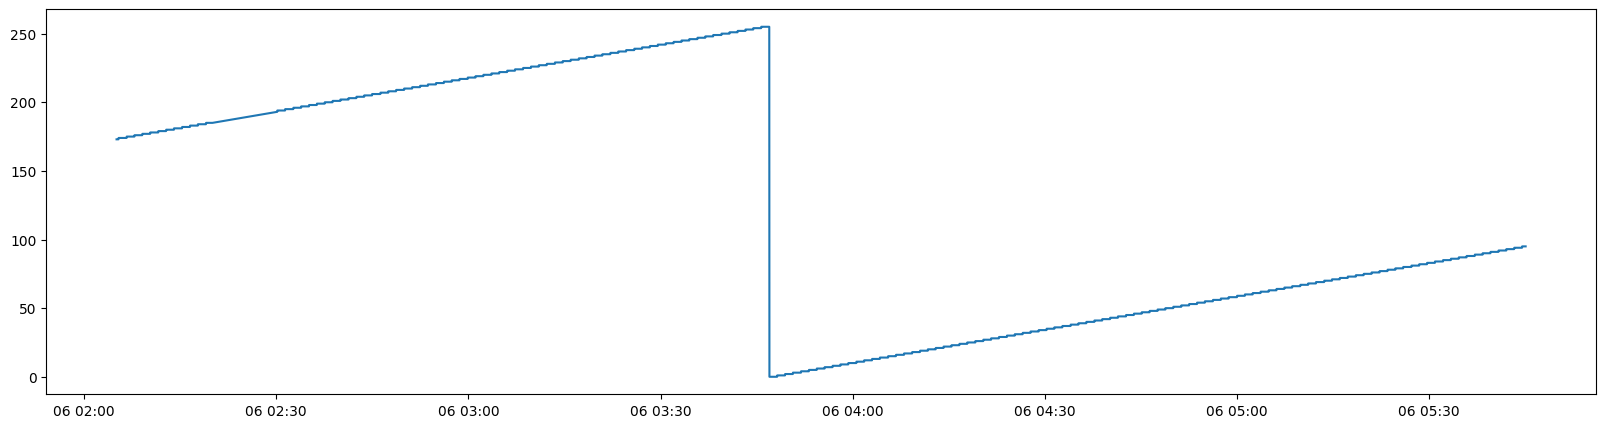

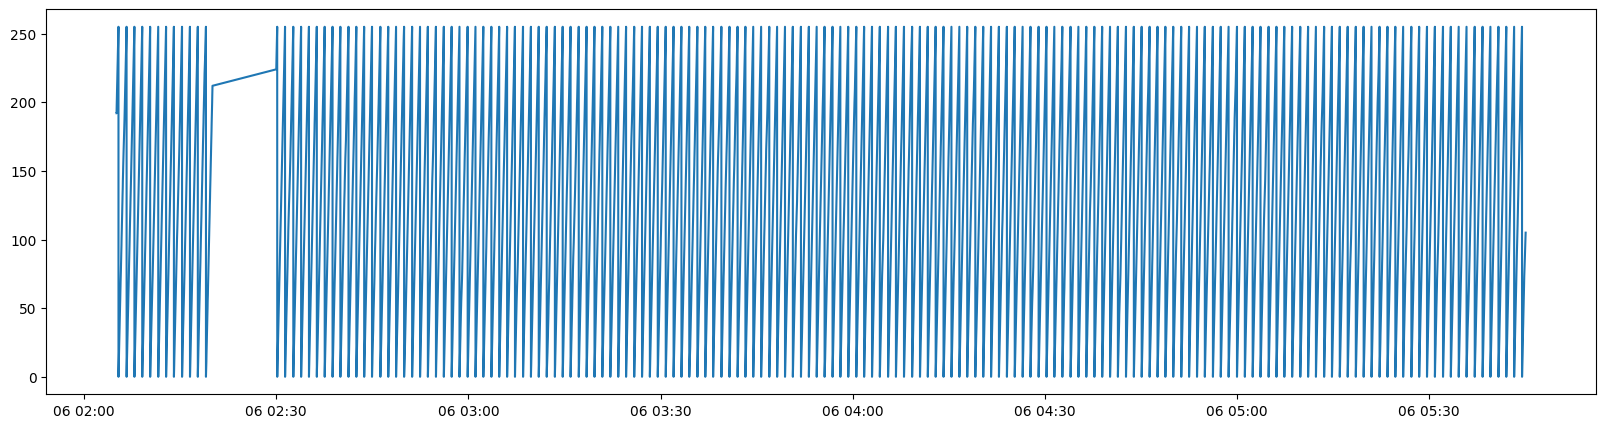

In [12]:
for col in df_bytes_converted.columns:
    plt.figure(figsize=(20,5))
    plt.plot(df_bytes_converted[col])
    plt.show()

In [13]:
df_train = df_bytes_converted.loc[:'2019-12-06 04:30:00'].copy().fillna(method='ffill')
#df_train_id = df_train.pop('id')
df_train.head(3)

byte_7  byte_11  byte_12  byte_13  byte_30  \
timestamp                                                                   
2019-12-06 02:05:04.415631056     255      231       59      188        1   
2019-12-06 02:05:04.415632010     255      231       59      188        1   
2019-12-06 02:05:04.532814026     255      231       59      188        1   

                               byte_35  byte_37  byte_49  byte_51  byte_52  \
timestamp                                                                    
2019-12-06 02:05:04.415631056        1        3        2      105      153   
2019-12-06 02:05:04.415632010        1        3        2      105      153   
2019-12-06 02:05:04.532814026        1        3        2      105      153   

                               ...  byte_91  byte_92  byte_109  byte_110  \
timestamp                      ...                                         
2019-12-06 02:05:04.415631056  ...       60      253         0         0   
2019-12-06 02:05:04.415632010  ...       60      253         0         0   
2019-12-06 02:05:04.532814026  ...       60      253         0         0   

                               byte_111  byte_112  byte_113  byte_114  \
timestamp                                                               
2019-12-06 02:05:04.415631056         0         0         0        12   
2019-12-06 02:05:04.415632010         0         0         0        12   
2019-12-06 02:05:04.532814026         0         0         0        12   

                               byte_133  byte_134  
timestamp                                          
2019-12-06 02:05:04.415631056       173       192  
2019-12-06 02:05:04.415632010       173       192  
2019-12-06 02:05:04.532814026       173       193  

[3 rows x 33 columns]

In [14]:
anomaly_idxs = [['2019-12-06 04:30:55', '2019-12-06 04:33:55'],
                ['2019-12-06 04:43:55', '2019-12-06 04:46:55'],
                ['2019-12-06 04:56:55', '2019-12-06 04:59:55'], 
                ['2019-12-06 05:09:55', '2019-12-06 05:12:55'], 
                ['2019-12-06 05:22:55', '2019-12-06 05:25:55']]

In [15]:
df_test = df_bytes_converted.loc['2019-12-06 04:30:00':].copy().fillna(method='ffill').fillna(method='bfill')
#df_test_id = df_test.pop('id')

df_test['anomaly'] = 0

for idx in anomaly_idxs:
    df_test['anomaly'].loc[idx[0]:idx[1]] = 1

df_test.head(3)

byte_7  byte_11  byte_12  byte_13  byte_30  \
timestamp                                                                   
2019-12-06 04:30:00.014081001     255      234       51       51        1   
2019-12-06 04:30:00.014082909     255      234       51       51        1   
2019-12-06 04:30:00.518059968     255      234       51       51        1   

                               byte_35  byte_37  byte_49  byte_51  byte_52  \
timestamp                                                                    
2019-12-06 04:30:00.014081001        1        2        2      128      170   
2019-12-06 04:30:00.014082909        1        2        2      128      170   
2019-12-06 04:30:00.518059968        1        2        2      128      170   

                               ...  byte_92  byte_109  byte_110  byte_111  \
timestamp                      ...                                          
2019-12-06 04:30:00.014081001  ...      235         0         0         0   
2019-12-06 04:30:00.014082909  ...      235         0         0         0   
2019-12-06 04:30:00.518059968  ...      235         0         0         0   

                               byte_112  byte_113  byte_114  byte_133  \
timestamp                                                               
2019-12-06 04:30:00.014081001         0         0        12        34   
2019-12-06 04:30:00.014082909         0         0        12        34   
2019-12-06 04:30:00.518059968         0         0        12        34   

                               byte_134  anomaly  
timestamp                                         
2019-12-06 04:30:00.014081001       202        0  
2019-12-06 04:30:00.014082909       202        0  
2019-12-06 04:30:00.518059968       203        0  

[3 rows x 34 columns]

In [16]:
summary = {}

## Подготовка train/test

In [17]:
x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 33)
            x_test: (30002, 33)
            y_test: (30002,)


## OC SVM

In [18]:
description='SWAT_Dec19_bytes_svm_default'

model = OCSVM()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)

2022-09-05 13:18:03.275807: find saved model: ./saved_models/SWAT_Dec19_bytes_svm_default, loading...


In [19]:
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

SWAT_Dec19_bytes_svm_default
f1_score: 0.45
accuracy_score: 0.51
precision_score: 0.29
recall_score: 1.00


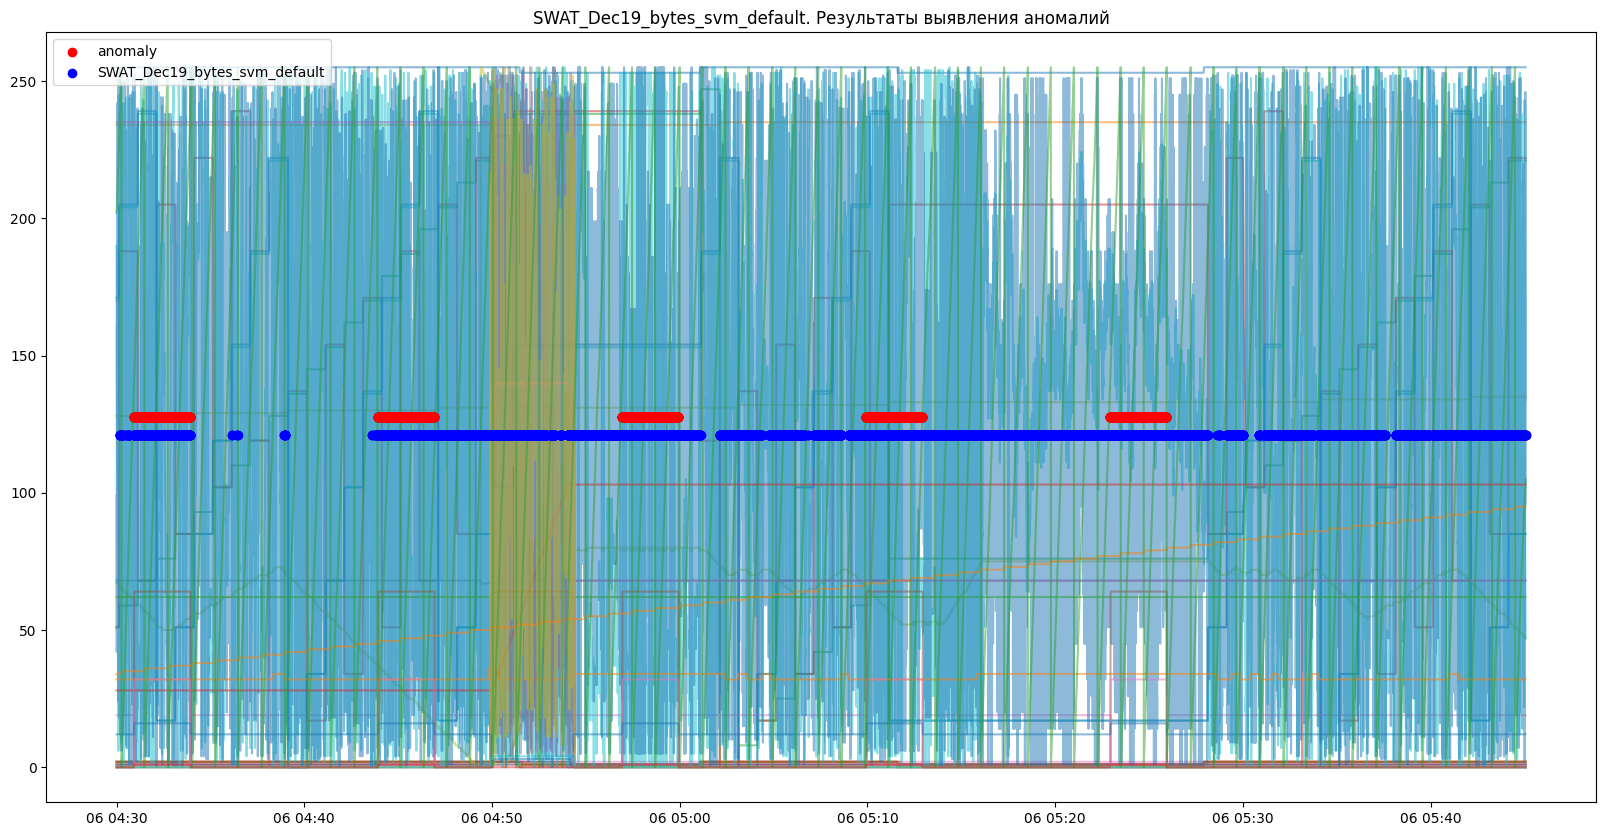

In [20]:
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (MinMax)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 33)
            x_test: (30002, 33)
            y_test: (30002,)
2022-09-05 13:18:07.029959: find saved model: ./saved_models/SWAT_Dec19_bytes_svm_minmax, loading...
SWAT_Dec19_bytes_svm_minmax
f1_score: 0.50
accuracy_score: 0.60
precision_score: 0.33
recall_score: 1.00


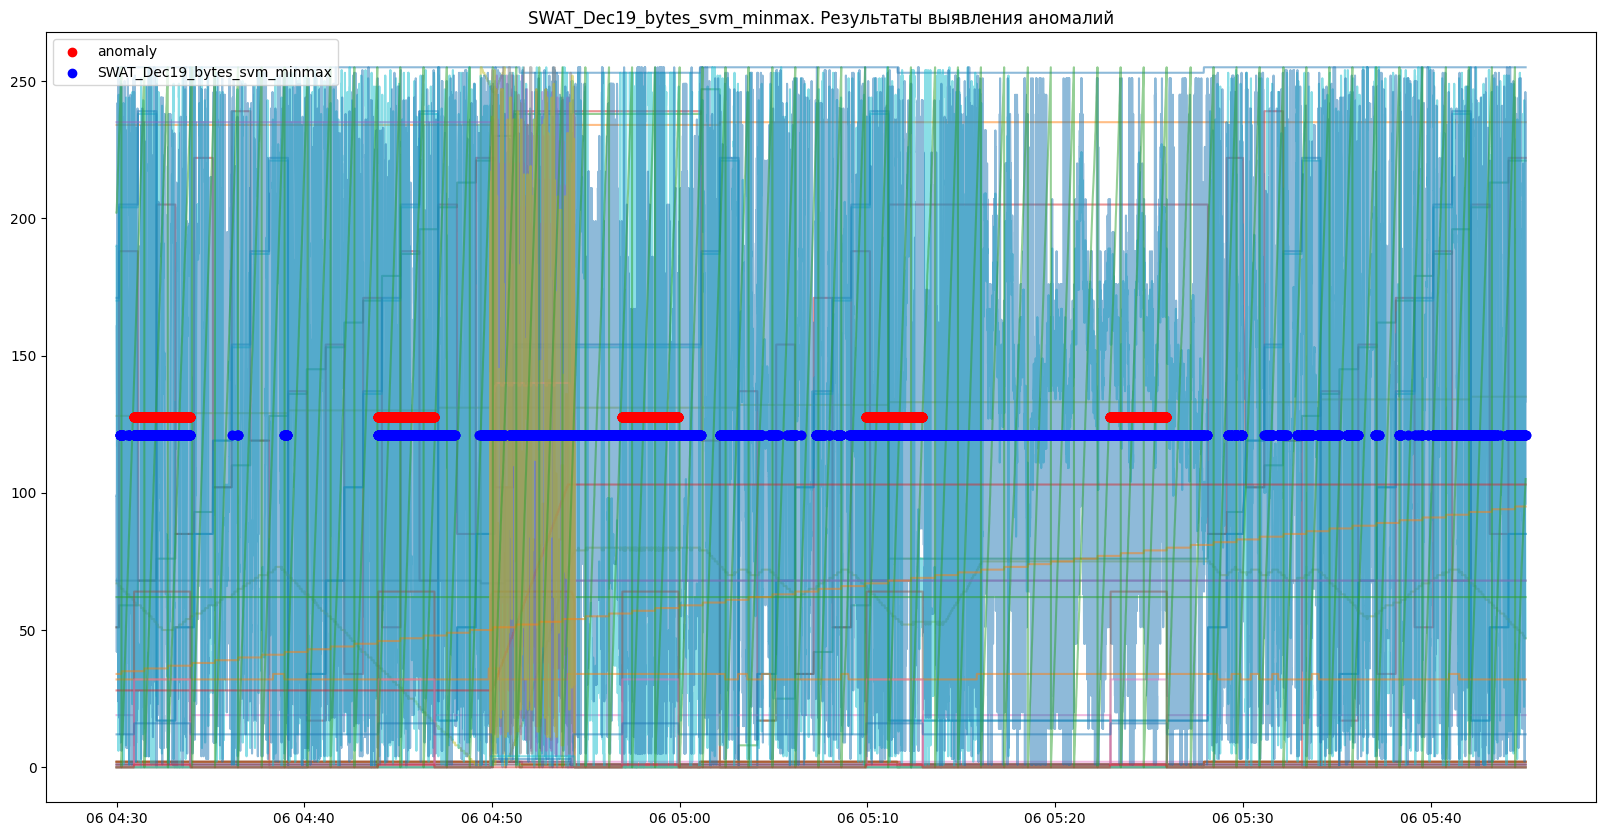

In [21]:
description='SWAT_Dec19_bytes_svm_minmax'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(),
                                        scaler='MinMax')

predictor = Predictor(model, [x_train, x_test, y_test], descr=description)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## LOF

In [22]:
anomaly_idx = [i for i in range(len(y_test)) if y_test[i] == 1]

In [23]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 33)
            x_test: (30002, 33)
            y_test: (30002,)


/opt/python37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


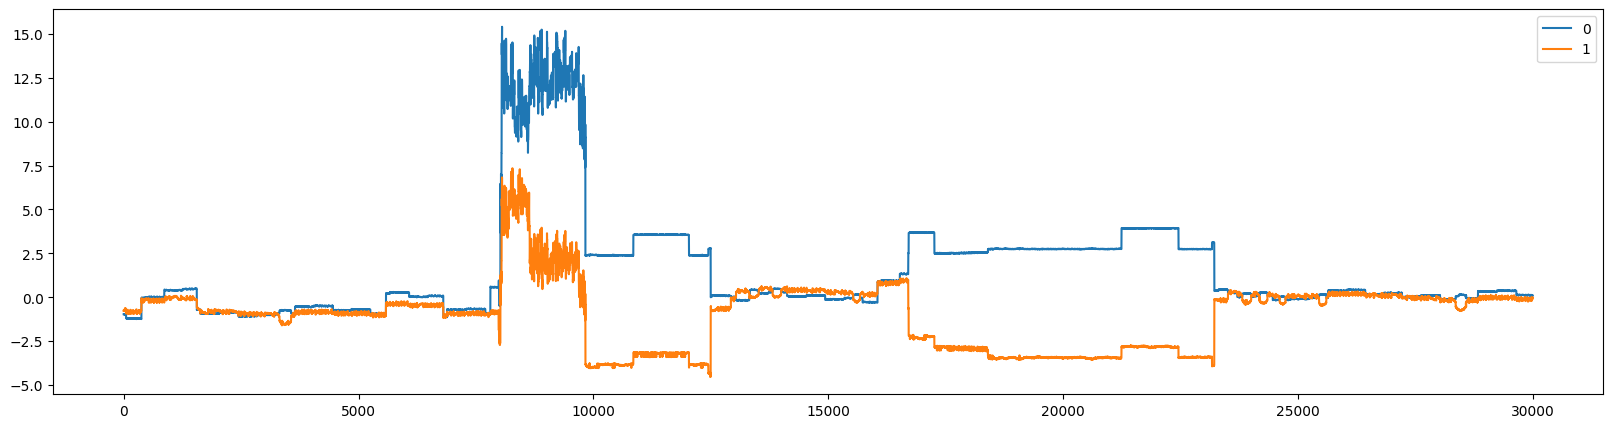

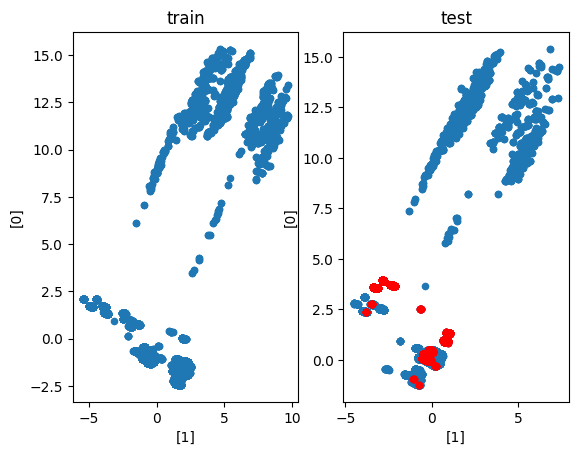

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(x_train)

x_train_2d = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_2d = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_2d.plot(figsize=(20,5))

fig, (ax, ax_test) = plt.subplots(1, 2)
x_train_2d.plot.scatter(x=[1], y=[0], title='train', ax=ax)
x_test_2d.plot.scatter(x=[1], y=[0], title='test', ax=ax_test)
x_test_2d.iloc[anomaly_idx].plot.scatter(x=[1], y=[0], title='test', c='r', ax=ax_test)
plt.show()

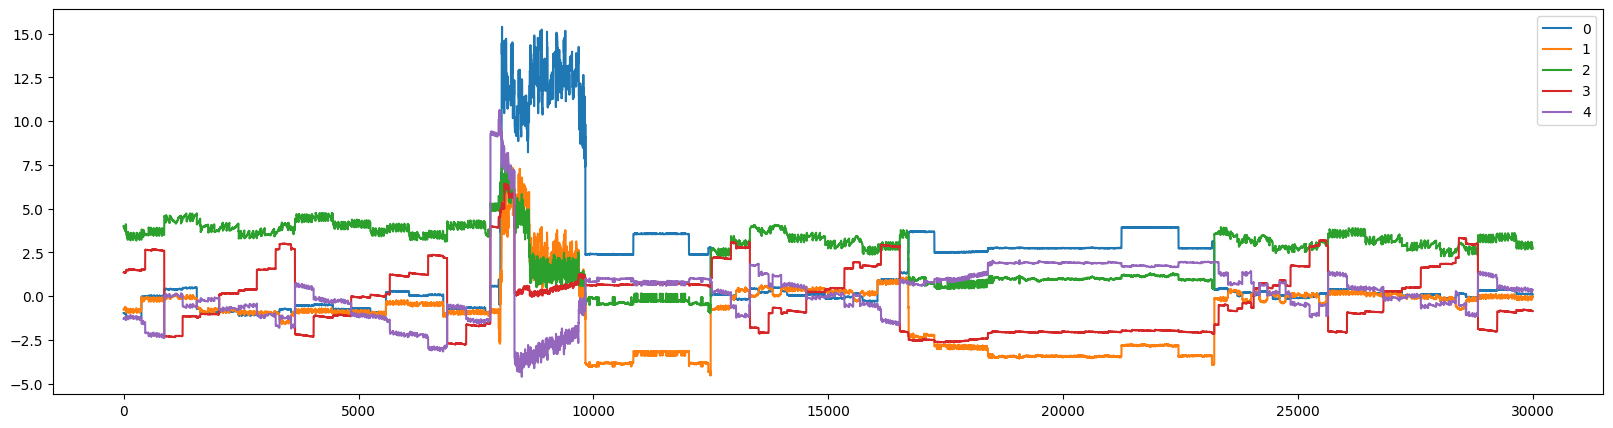

In [25]:
N_COMPONENTS = 5

pca = PCA(n_components=N_COMPONENTS)
principalComponents = pca.fit(x_train)

x_train_pca = pd.DataFrame(data = principalComponents.transform(x_train))
x_test_pca = pd.DataFrame(data = principalComponents.transform(x_test))
x_test_pca.plot(figsize=(20,5))
plt.show()

In [26]:
model = LOF()

2022-09-05 13:18:12.019826: refit model...
Train prediction score statistics
            min: -17.55446253369579
            mean: -1.0743302805440114
            max: -0.809501882096864


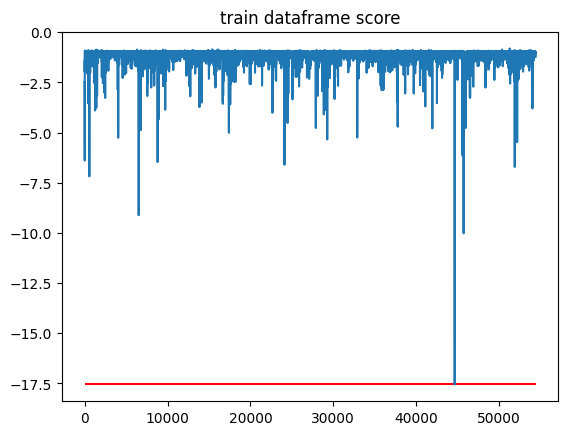

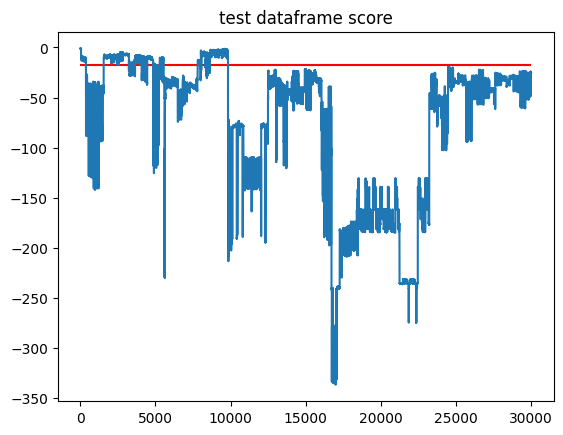

SWAT_Dec19_bytes_lof_n5
f1_score: 0.39
accuracy_score: 0.37
precision_score: 0.24
recall_score: 1.00


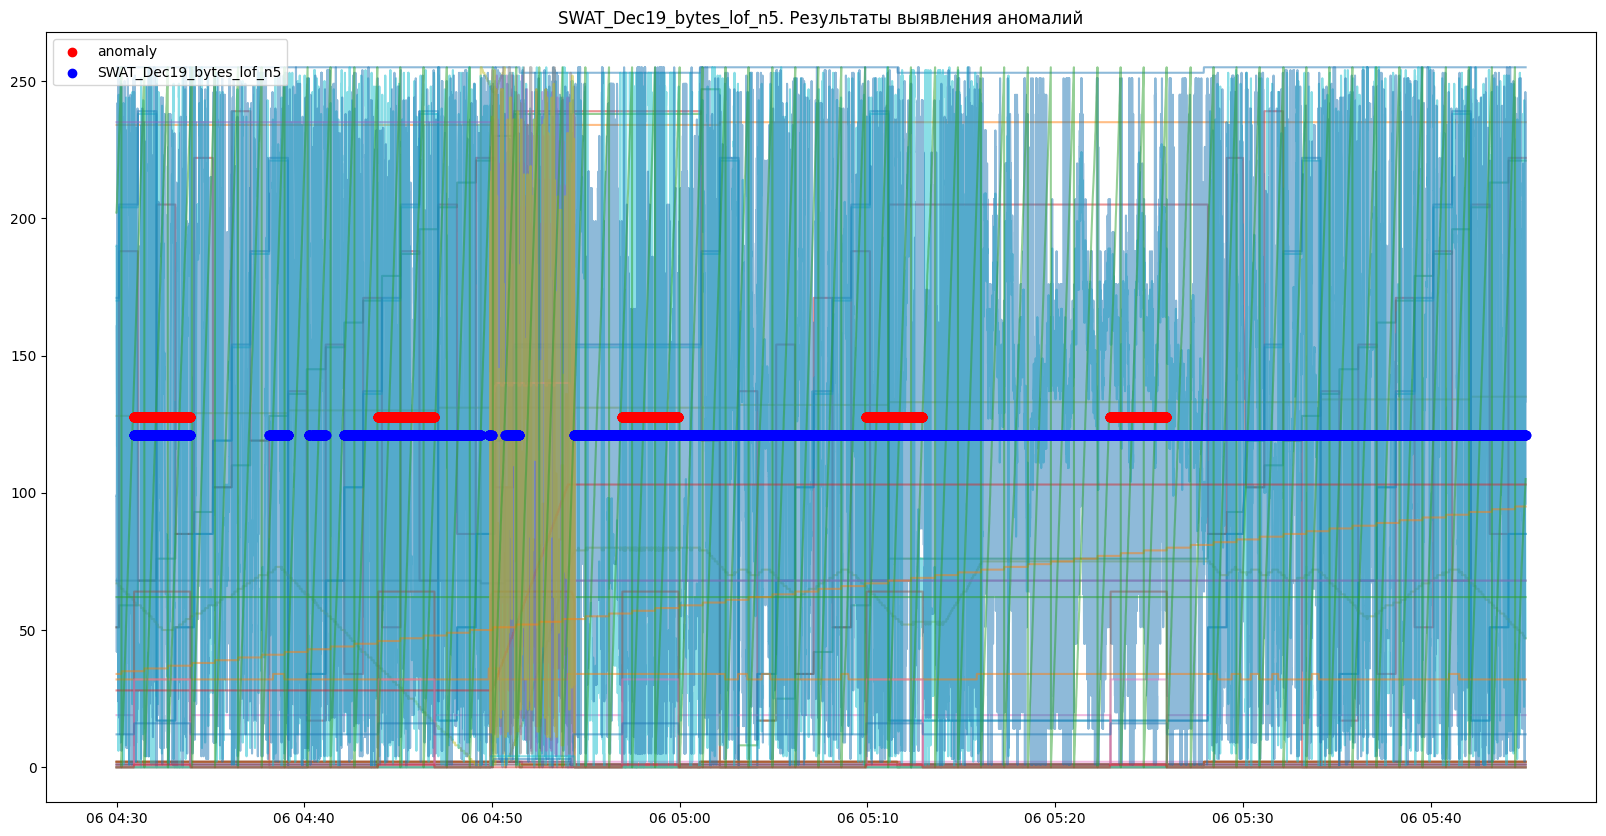

In [27]:
description = f'SWAT_Dec19_bytes_lof_n{N_COMPONENTS}'
predictor = Predictor(model, [x_train_pca, x_test_pca, y_test], descr=description, resave_model=True)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

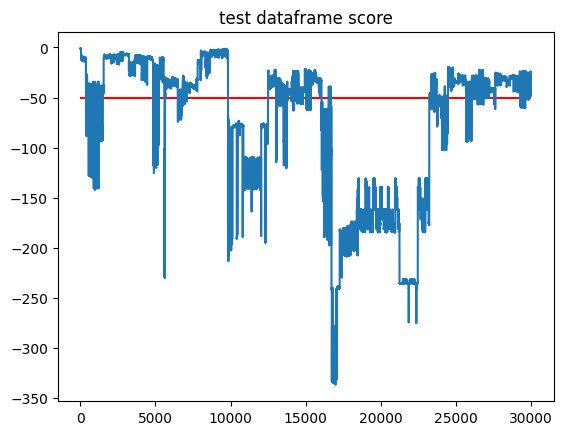

SWAT_Dec19_bytes_lof_n5
f1_score: 0.47
accuracy_score: 0.67
precision_score: 0.35
recall_score: 0.73


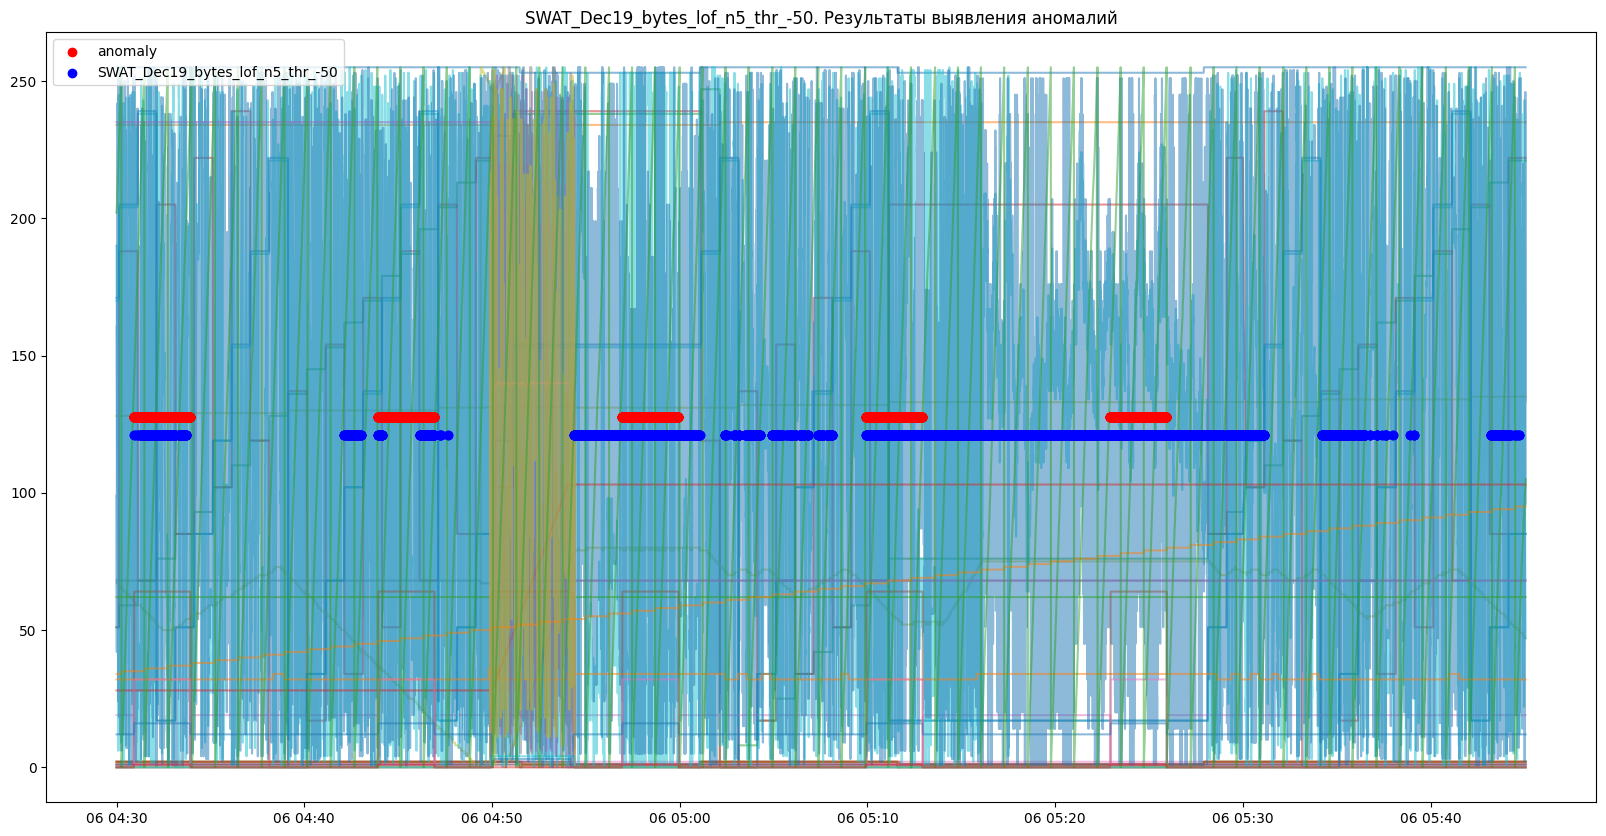

In [28]:
threshold = -50
description = f'SWAT_Dec19_bytes_lof_n{N_COMPONENTS}_thr_{threshold}'

y_pred = predictor.get_anomalies(threshold = threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## iForest

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 33)
            x_test: (30002, 33)
            y_test: (30002,)
2022-09-05 13:18:20.102479: find saved model: ./saved_models/SWAT_Dec19_bytes_iF_default, loading...


/opt/python37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SWAT_Dec19_bytes_iF_default
f1_score: 0.00
accuracy_score: 0.80
precision_score: 0.00
recall_score: 0.00


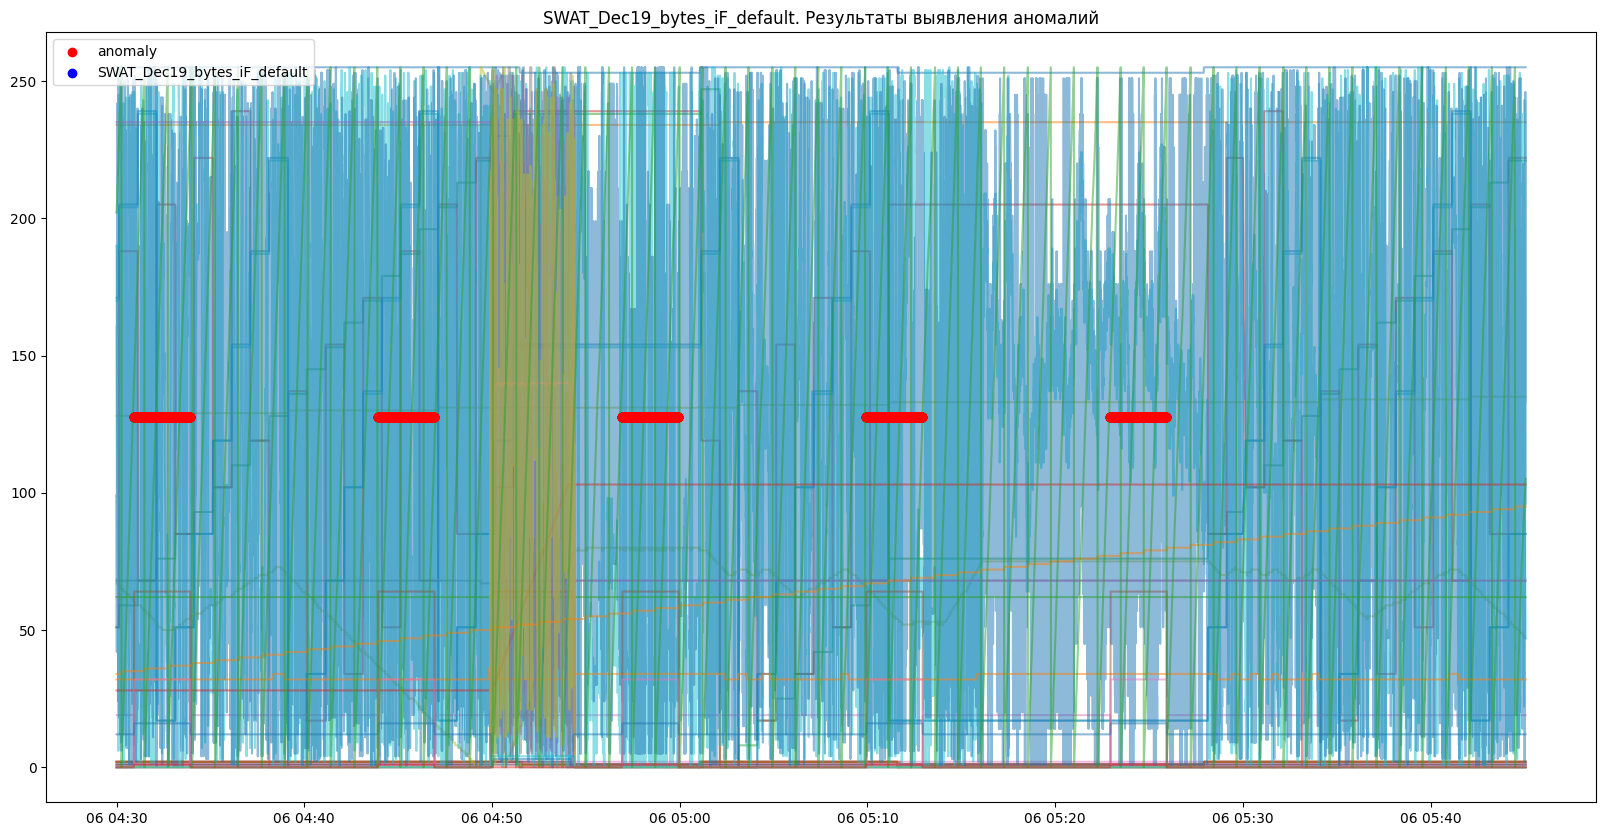

In [29]:
description = f'SWAT_Dec19_bytes_iF_default'

x_train, x_test, y_test = get_traintest(df_train.copy(), df_test.copy())

model = iForest()

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=False)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 33)
            x_test: (30002, 33)
            y_test: (30002,)
2022-09-05 13:18:23.384731: refit model...
SWAT_Dec19_bytes_iF_n_100_c_005
f1_score: 0.55
accuracy_score: 0.78
precision_score: 0.47
recall_score: 0.67


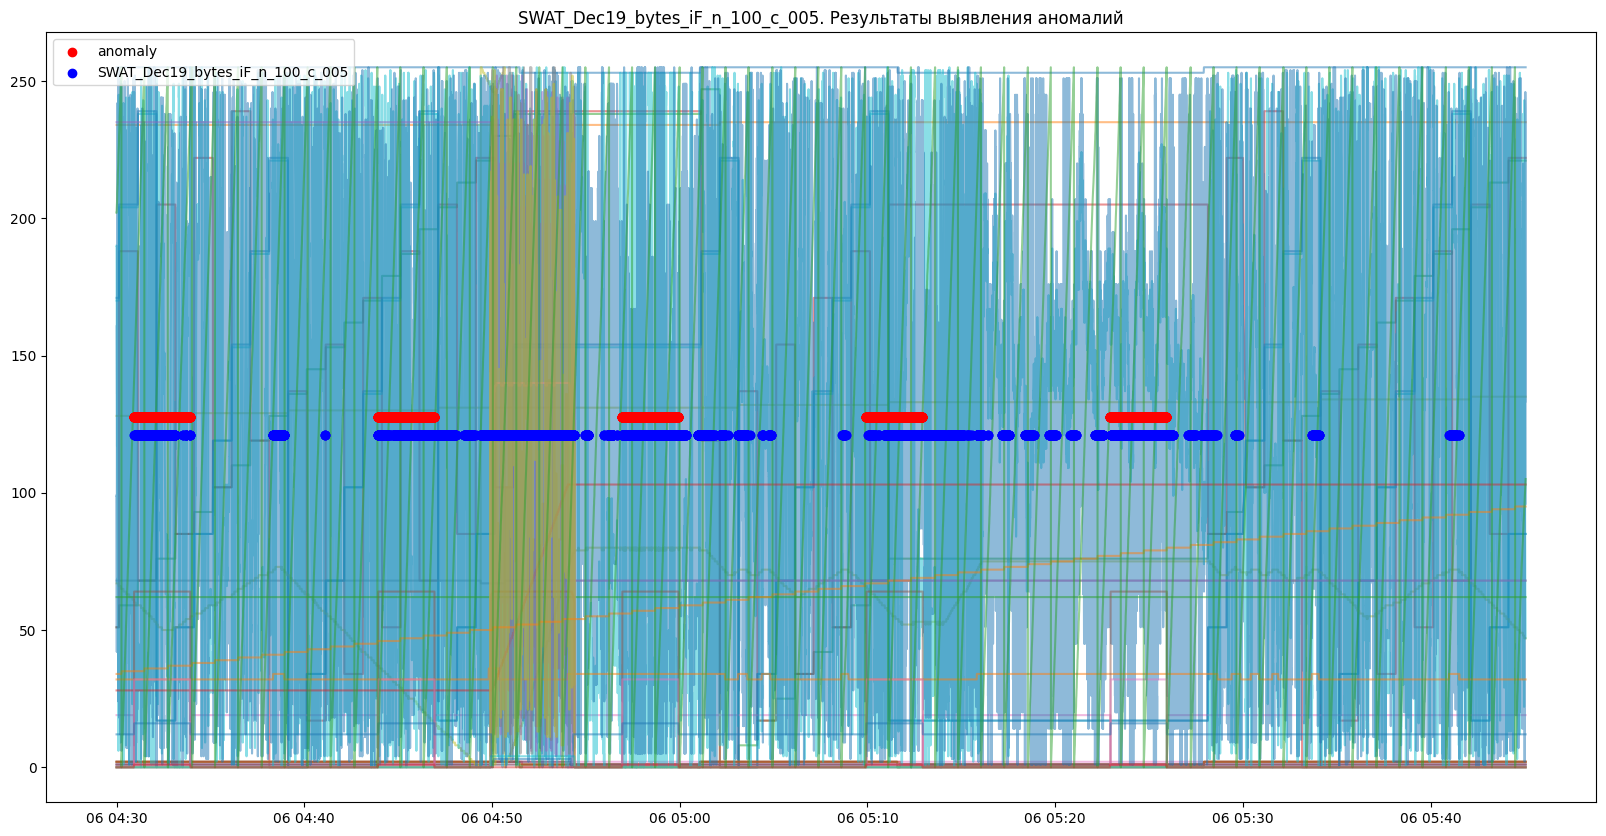

In [30]:
n_estimators, contamination = 100, 0.05
description = f"SWAT_Dec19_bytes_iF_n_{n_estimators}_c_{str(contamination).replace('.','')}"

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

model = iForest(n_estimators=n_estimators, contamination=contamination)

predictor = Predictor(model, [x_train, x_test, y_test], descr=description, resave_model=True)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

## Autoencoder

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Resampling... (1T)
(146, 33), (76, 33), (76,),
Create sequences with window size 30...
Размеры выборок:
            x_train: (54377, 30, 33)
            x_test: (29973, 30, 33)
            y_test: (29973, 30)
2022-09-05 13:55:42.743564: refit model...
Epoch 1/10
55/55 [==============================] - 8s 155ms/step - loss: 35.7110
Epoch 2/10
55/55 [==============================] - 8s 154ms/step - loss: 74.5499
Epoch 3/10
55/55 [==============================] - 8s 154ms/step - loss: 13.2997
Epoch 4/10
55/55 [==============================] - 8s 154ms/step - loss: 17.4306
Epoch 5/10
55/55 [==============================] - 8s 154ms/step - loss: 2.4332
Epoch 6/10
55/55 [==============================] - 8s 154ms/step - loss: 2.0309
Epoch 7/10
55/55 [==============================] - 8s 154ms/step - loss: 1.8672
Epoch 8/10
55/55 [==============================] - 8s 154ms/step - loss: 1.6261
Epoch 9/10
55/55 

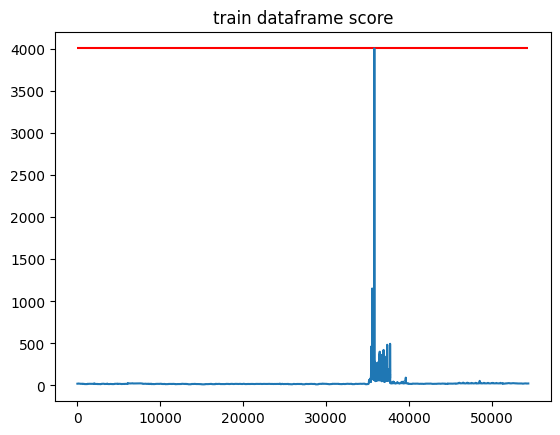

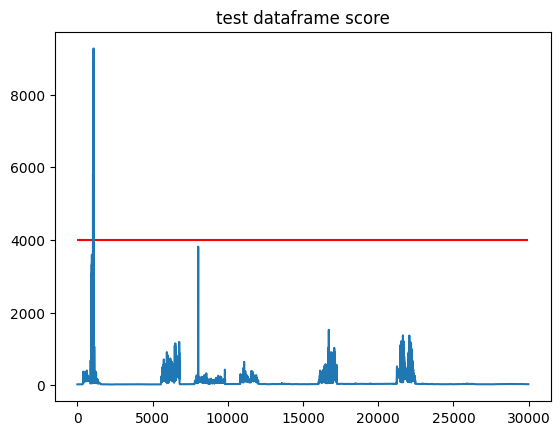

(29973,)
SWAT_Dec19_bytes_ae_lstm_window_30_resample_1T
f1_score: 0.00
accuracy_score: 0.80
precision_score: 1.00
recall_score: 0.00


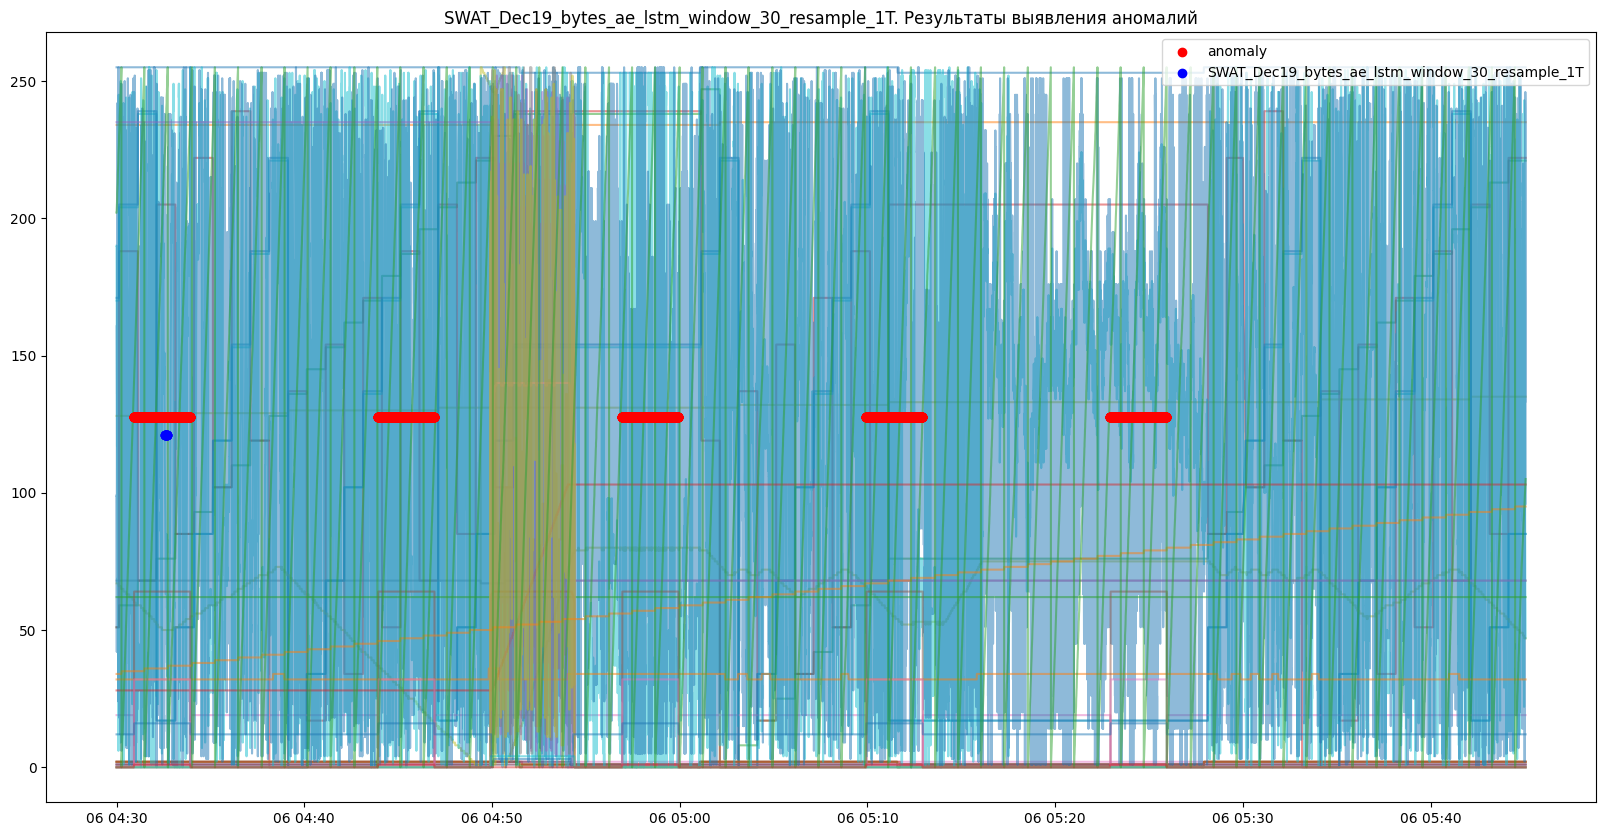

In [32]:
window_size = 30
resample_rate = '1T'

description = f'SWAT_Dec19_bytes_ae_lstm_window_{window_size}_resample_{resample_rate}'

x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy(), 
                                        window_size=window_size, 
                                        resample_rate=resample_rate)

model = AE_LSTM()

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description, 
                      window_size=window_size,
                      resave_model=False)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=description)

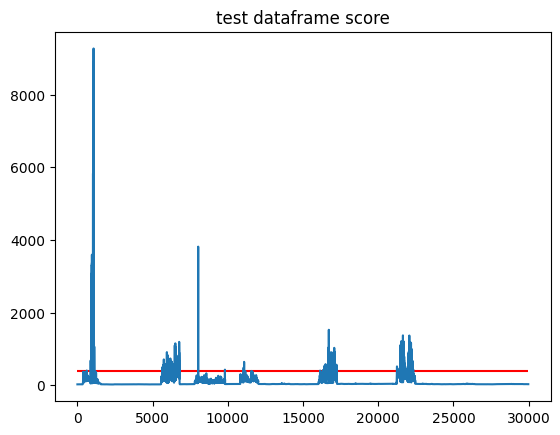

(29973,)
SWAT_Dec19_bytes_ae_lstm_window_30_resample_1T
f1_score: 0.23
accuracy_score: 0.82
precision_score: 0.99
recall_score: 0.13


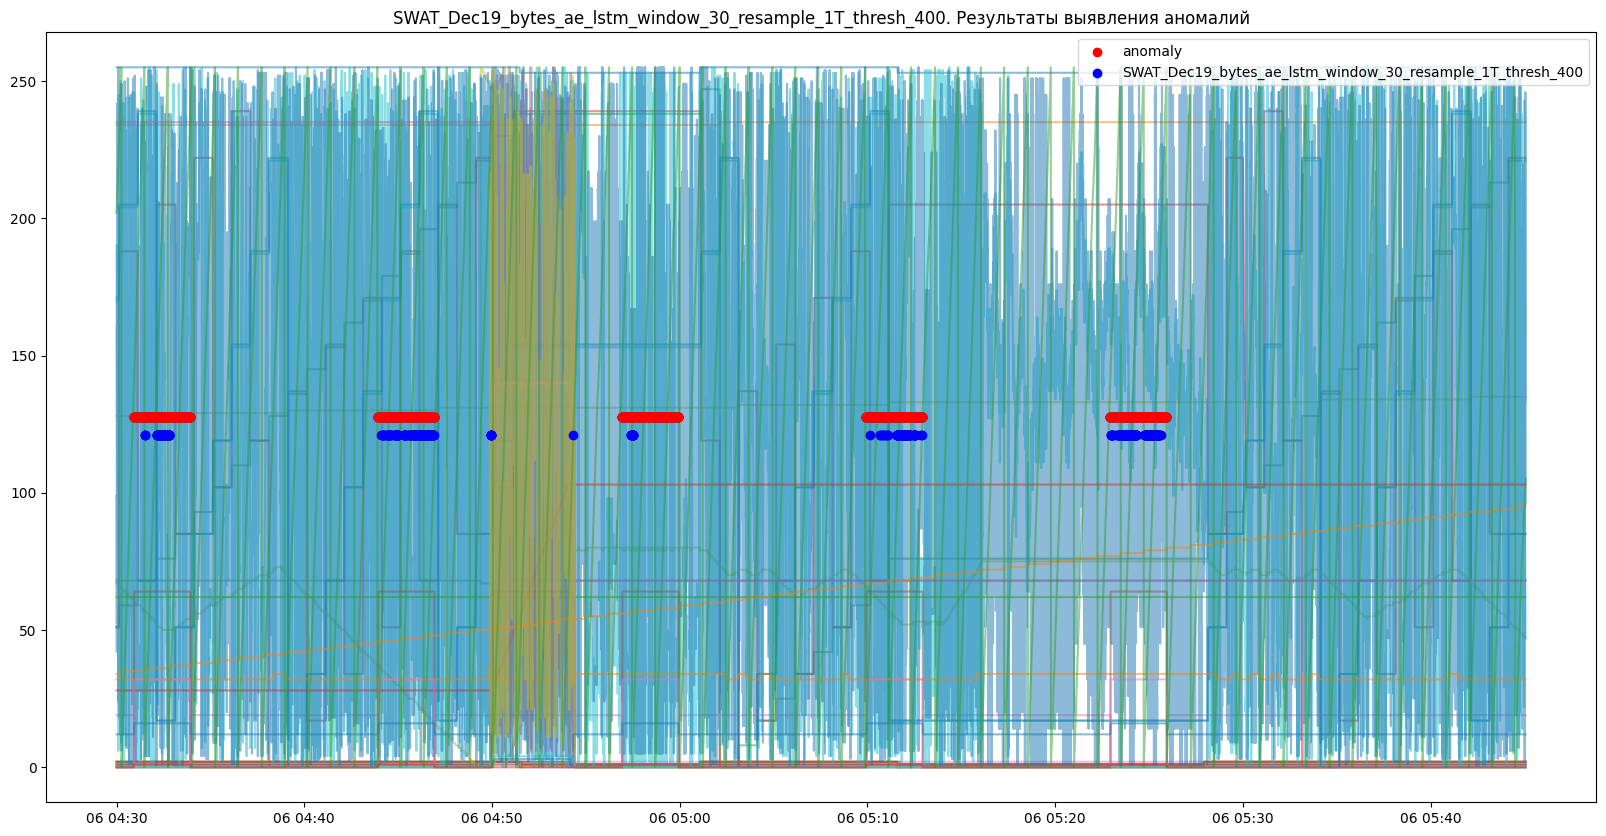

In [33]:
threshold=400
y_pred = predictor.get_anomalies(threshold=threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f"{description}_thresh_{threshold}")

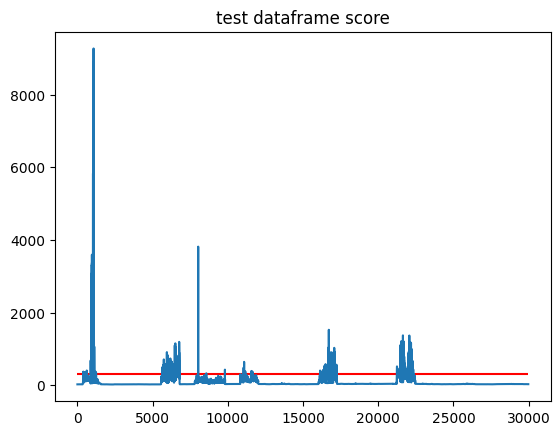

(29973,)
SWAT_Dec19_bytes_ae_lstm_window_30_resample_1T
f1_score: 0.35
accuracy_score: 0.84
precision_score: 0.99
recall_score: 0.22


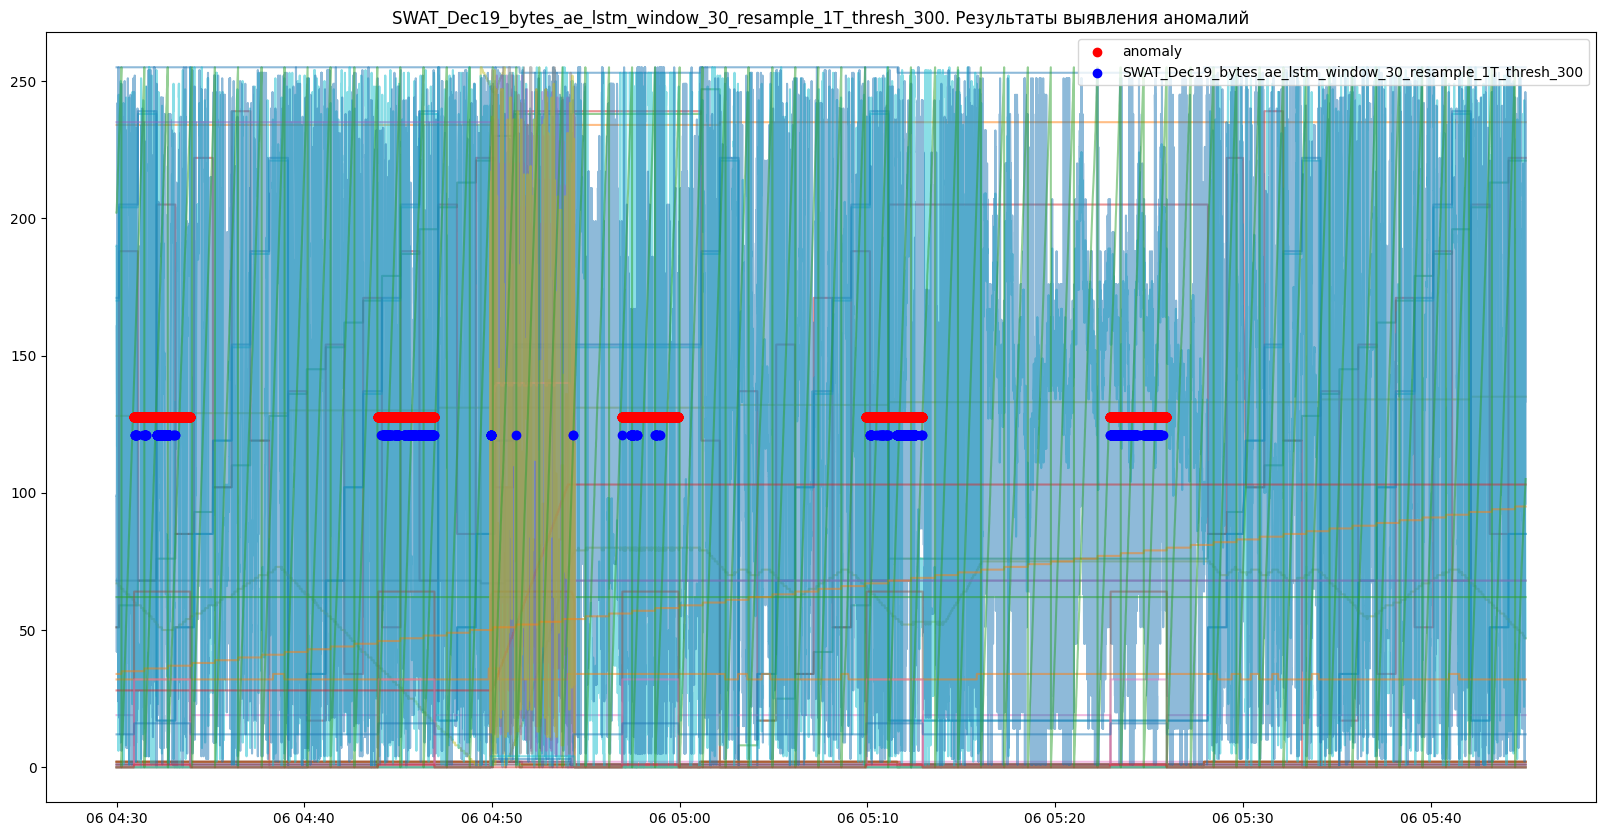

In [34]:
threshold=300
y_pred = predictor.get_anomalies(threshold=threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f"{description}_thresh_{threshold}")

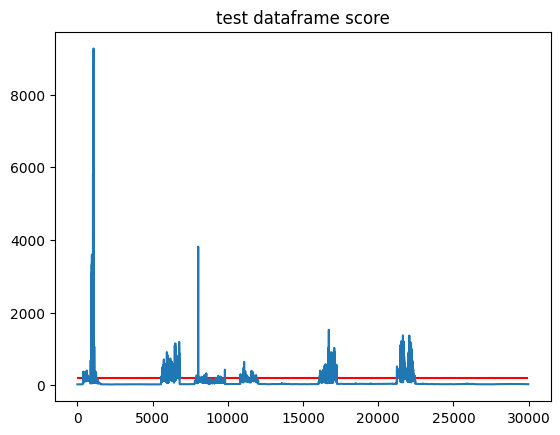

(29973,)
SWAT_Dec19_bytes_ae_lstm_window_30_resample_1T
f1_score: 0.62
accuracy_score: 0.89
precision_score: 0.97
recall_score: 0.45


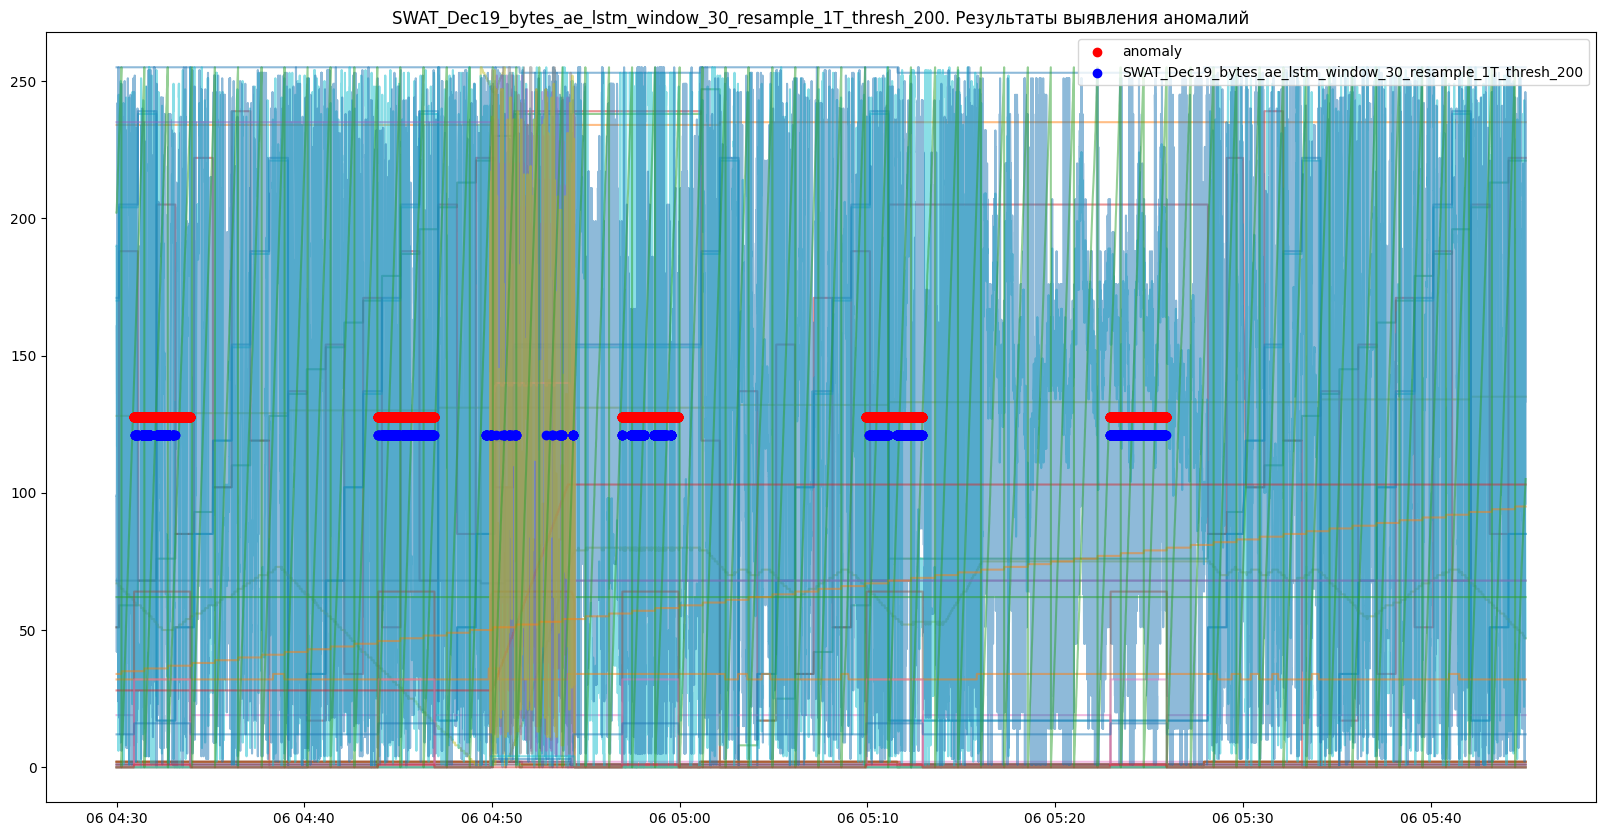

In [35]:
threshold=200
y_pred = predictor.get_anomalies(threshold=threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test[:,0], y_pred, descr=f"{description}_thresh_{threshold}")

## SOM

In [36]:
x_train, x_test, y_test = get_traintest(df_train.copy(), 
                                        df_test.copy())

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 23968, 1: 6034})
Размеры выборок:
            x_train: (54406, 33)
            x_test: (30002, 33)
            y_test: (30002,)


2022-09-05 14:00:27.611422: refit model...
50000


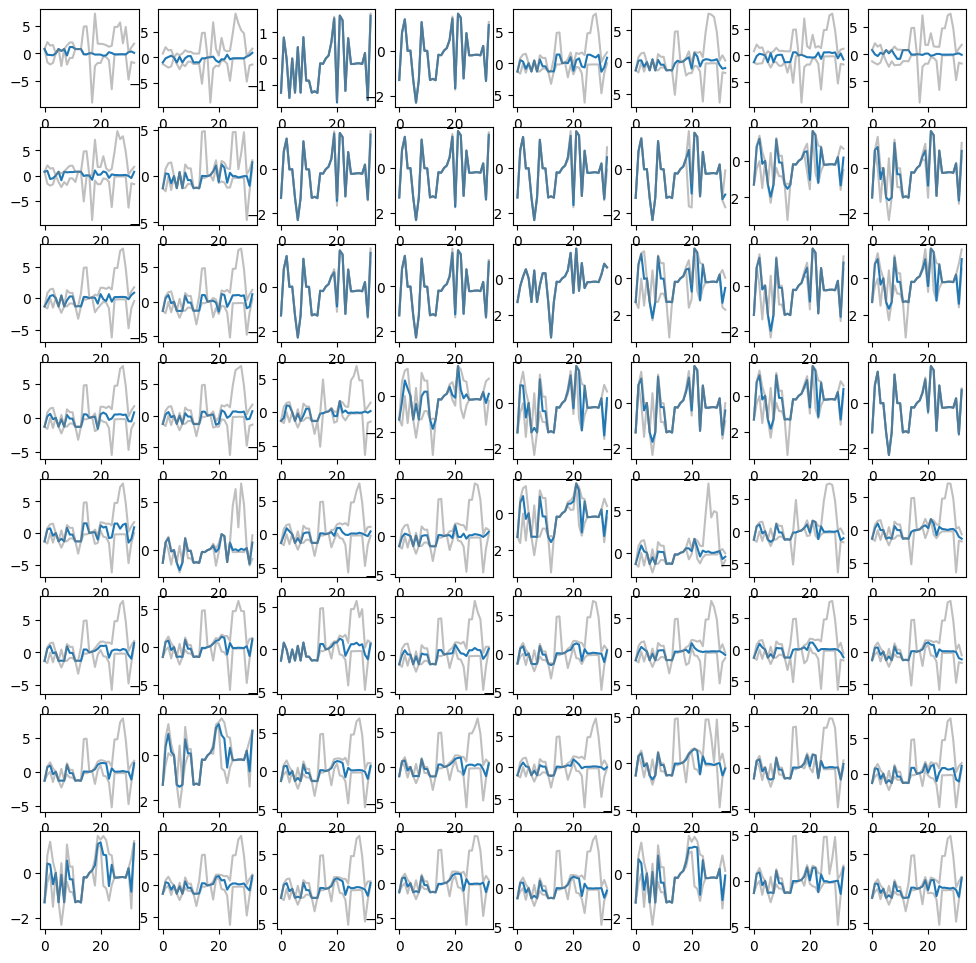

IntProgress(value=0, description='Computing', max=30002, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IntProgress(value=0, description='Computing', max=54406, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Train prediction score statistics
            min: 0.360647908394834
            mean: 44.147357723650686
            max: 227.56382869522338


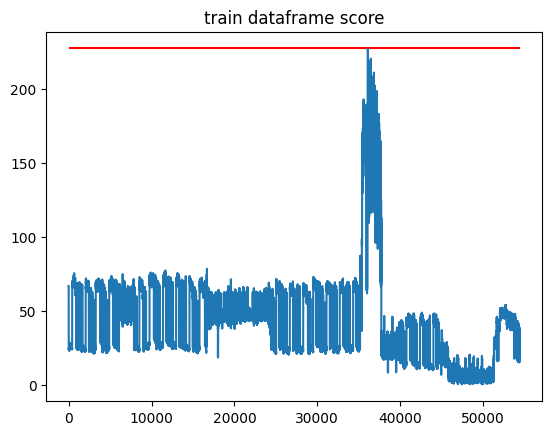

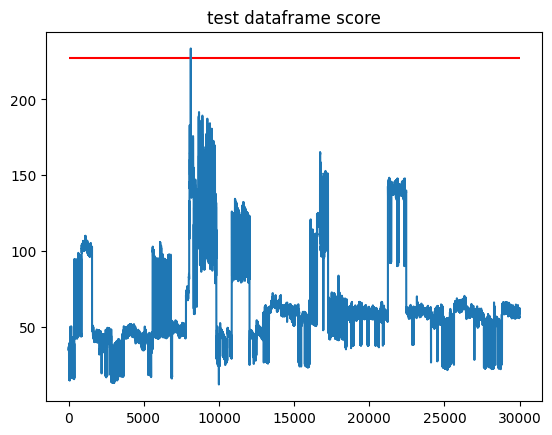

(30002,)
SWAT_Dec19_bytes_som_default
f1_score: 0.00
accuracy_score: 0.80
precision_score: 0.00
recall_score: 0.00


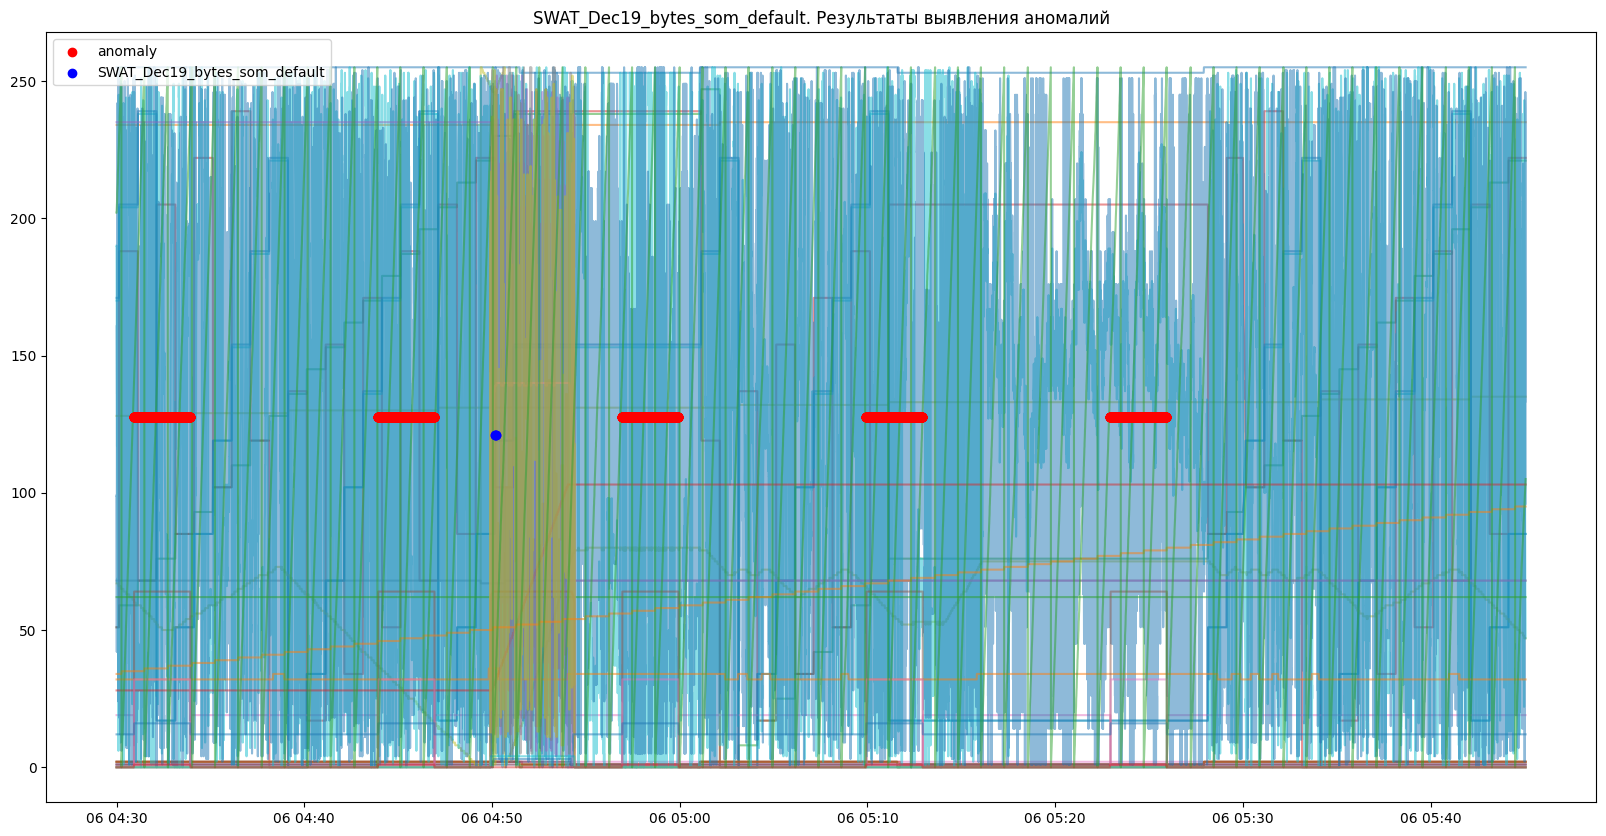

In [37]:
description = f'SWAT_Dec19_bytes_som_default'

model = SOM(x_train)

predictor = Predictor(model, 
                      [x_train, x_test, y_test], 
                      descr=description,
                      resave_model=True)

y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=description)

IntProgress(value=0, description='Computing', max=30002, style=ProgressStyle(bar_color='#61dc8a'))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

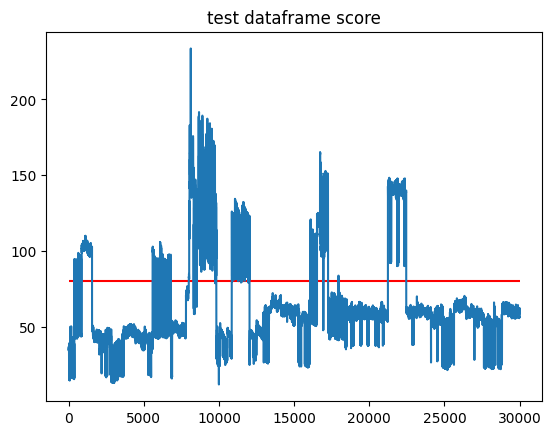

(30002,)
SWAT_Dec19_bytes_som_default
f1_score: 0.75
accuracy_score: 0.89
precision_score: 0.72
recall_score: 0.78


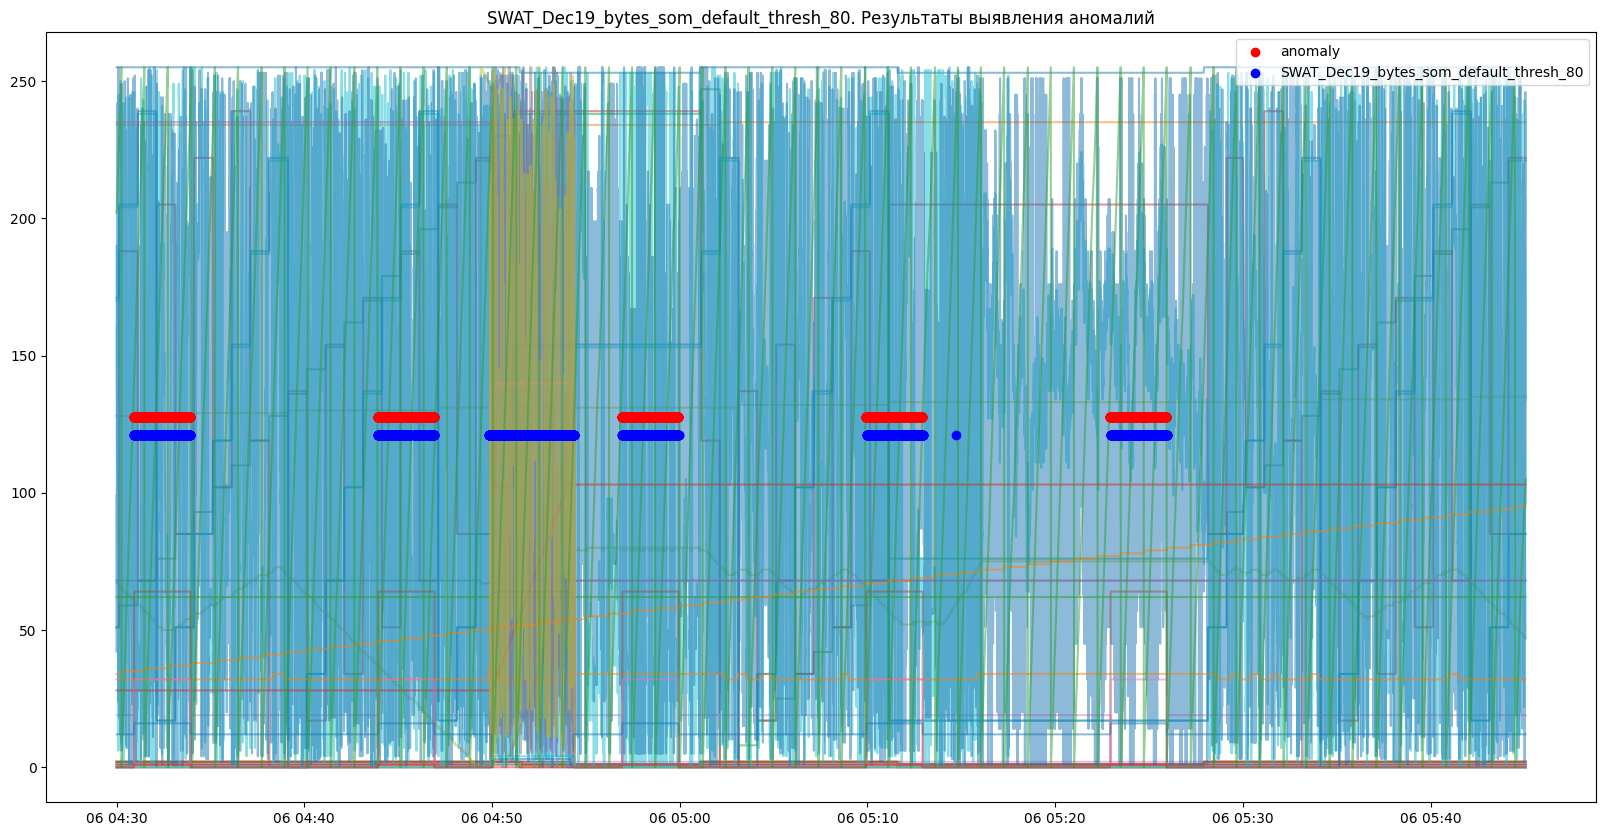

In [39]:
threshold = 80
y_pred = predictor.get_anomalies(threshold=threshold)
summary[description] = predictor.get_score()
plot_result(df_test, y_test, y_pred, descr=f"{description}_thresh_{threshold}")

# Сводная таблица

In [40]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

df_summary = pd.DataFrame(summary).T
df_summary.style.background_gradient(cmap='Blues')